# 성인 인구조사 소득 예측 대회

한국과 마찬가지로 미국도 주기적으로 성인을 대상으로 한 여러 인구조사를 시행합니다.
이 대회는 1994년 미국 성인을 대상으로 조사한 데이터를 바탕으로 진행됩니다.

여러분은 이 데이터에서 각 사람의 소득을 예측하면 됩니다.

나이, 결혼 여부, 직종 등 총 14개의 feature를 통해 예측을 하면 됩니다.
예측해야 하는 값은 간단합니다.

연소득이 $50,000 이 넘는다면 1
연소득이 $50,000 이 넘지 않는다면 0

## 데이터 설명

* 데이터 세부 설명
* train/test는 14개의 columns으로 구성되어 있고, train은 예측해야 하는 target 값 feature까지 1개가 추가로 있습니다. 각 데이터는 다음을 의미합니다.

* id
* age : 나이
* workclass : 고용 형태
* fnlwgt : 사람 대표성을 나타내는 가중치 (final weight의 약자)
* education : 교육 수준
* education_num : 교육 수준 수치
* marital_status: 결혼 상태
* occupation : 업종
* relationship : 가족 관계
* race : 인종
* sex : 성별
* capital_gain : 양도 소득
* capital_loss : 양도 손실
* hours_per_week : 주당 근무 시간
* native_country : 국적
* income : 수익 (예측해야 하는 값)
* >50K : 1
* <=50K : 0

## <center style="background-color:black; width:40%;">Contents</center>
* [데이터 읽어오기.](#데이터_읽어오기)
* [목표변수 0, 1 변환](#목표변수)
* [연령 카테고리화 및 연령대 별 50K이상 비율](#연령대)
* [소득 별 final weight 히스토그램 및 2 sample test](#FINAL_WEIGHT)
* [소득 별 교육 수준](#교육수준)
* [소득 별 결혼 여부](#결혼)
* [소득 별 업종](#업종)
* [소득 별 가족 관계](#가족)
* [소득 별 인종](#인종)
* [소득 별 성별](#성별)
* [인종 & 성별 별 소득이 50K가 넘는 비율](#파생1)
* [소득 별 양도 소득](#양도소득)
* [소득 별 양도 손실](#양도손실)
* [소득 별 주당 근무 시간](#주당근무시간)
* [소득 별 국적](#국적)
* [연속형 설명변수 간 상관계수](#상관)
* [결측치 및 이상치 도출](#결측치_이상치)
* [데이터 범주형 데이터 인코딩 및 목표변수 검증데이터셋 분류](#데이터_분류)
* [XGBOOST](#XGBOOST)
* [모델 평가](#평가)

<a class="anchor" id="데이터_읽어오기"></a>
## <center style="background-color:black; width:40%;">데이터 읽어오기.</center>

In [89]:
import numpy as np 
import pandas as pd 
import os
#데이터 구성 패키지
import pandas as pd
#행렬 연산 패키지
import numpy as np
#데이터 시각화 패키지
import matplotlib
#한글 폰트 적용
matplotlib.rc('font', family='Malgun Gothic')

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.stattools import omni_normtest
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/kakr-4th-competition/sample_submission.csv
/kaggle/input/kakr-4th-competition/train.csv
/kaggle/input/kakr-4th-competition/test.csv


In [90]:
plt.style.use(['dark_background'])
origin_data = pd.read_csv('/kaggle/input/kakr-4th-competition/train.csv')
data = origin_data.copy()

In [91]:
data.head()

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,40,Private,168538,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K
1,1,17,Private,101626,9th,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States,<=50K
2,2,18,Private,353358,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,<=50K
3,3,21,Private,151158,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,United-States,<=50K
4,4,24,Private,122234,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,?,<=50K


## * feature 중 workclass, fnlwgt, education 등의 일부 컬럼에서 이해하기 어려운 값들이 많이 있음.
## * feature 중에서도 fnlwgt, education_num 등이 어떤 도메인인지 알기 어려움.
## * 값들 중 null값은 없지만 '?'값이 있음. 

In [92]:
data.isnull().sum()

id                0
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

<a class="anchor" id="목표변수"></a>
## <center style="background-color:black; width:40%;">목표변수 0,1 변환.</center>

In [93]:
data['income'].describe()

count     26049
unique        2
top       <=50K
freq      19744
Name: income, dtype: object

In [94]:
data['income'].head()

0     >50K
1    <=50K
2    <=50K
3    <=50K
4    <=50K
Name: income, dtype: object

In [95]:
data['income'][data['income']=='>50K'] = 1
data['income'][data['income']=='<=50K'] = 0
origin_data['income'] = data['income']
origin_data['income'].astype(int)
origin_data['income'].describe()

count     26049
unique        2
top           0
freq      19744
Name: income, dtype: int64

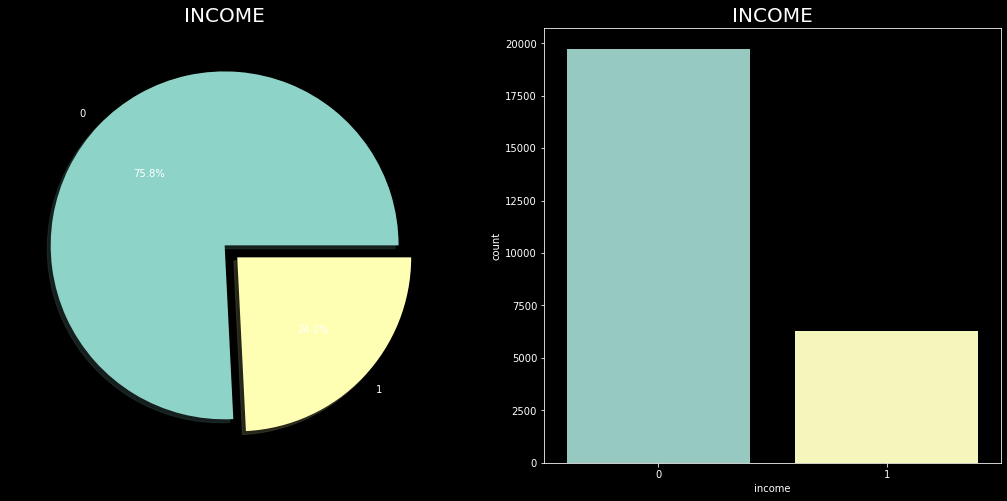

In [96]:
fig, ax = plt.subplots(1,2, figsize=(18,8))
data['income'].value_counts().plot.pie(explode=[0, 0.1], autopct = '%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('INCOME', size = 20, color = 'white')
ax[0].set_ylabel('')
sns.countplot('income', data=data, ax=ax[1])
ax[1].set_title('INCOME',size = 20, color = 'white')
plt.sca(ax[1])
plt.xticks(color = 'white')
plt.show()

## * 목표데이터는 Unbalanced 하다.

<a class="anchor" id="연령대"></a>
## <center style="background-color:black; width:80%;">연령 카테고리화 및 연령대 별 50K이상 비율.</center>

In [97]:
print(data['age'].describe())
data['age'][data['age']==90].count()

count    26049.000000
mean        38.569235
std         13.671489
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64


36

In [98]:
data['age'][(data['age'] >= 10) & (data['age'] < 20)] = 10
data['age'][(data['age'] >= 20) & (data['age'] < 30)] = 20
data['age'][(data['age'] >= 30) & (data['age'] < 40)] = 30
data['age'][(data['age'] >= 40) & (data['age'] < 50)] = 40
data['age'][(data['age'] >= 50) & (data['age'] < 60)] = 50
data['age'][(data['age'] >= 60) & (data['age'] < 70)] = 60
data['age'][(data['age'] >= 70) & (data['age'] < 80)] = 70
data['age'][(data['age'] >= 80) & (data['age'] < 90)] = 80
data['age'][(data['age'] >= 90) & (data['age'] < 100)] = 90


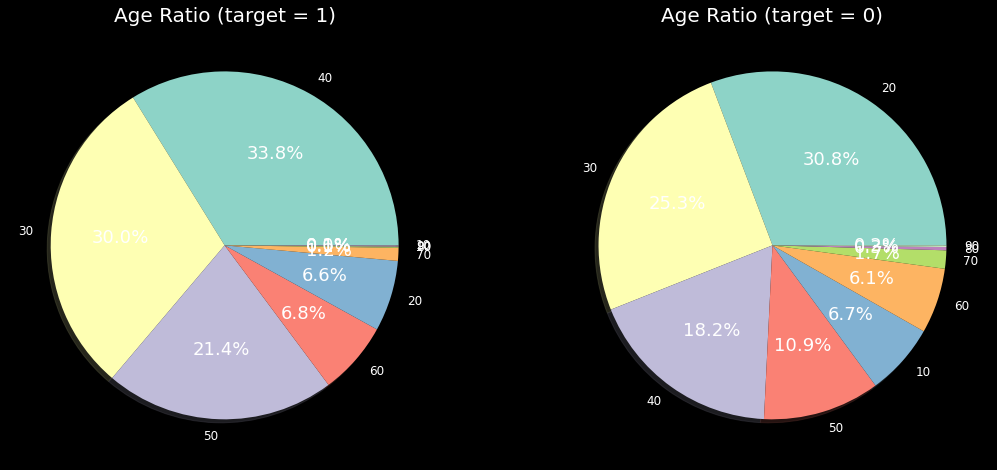

In [99]:
data_1_all = []
data_1 = data['age'][data['income'] == 1]
data_0 = data['age'][data['income'] == 0]
labels = []

data_count_1 = data_1.value_counts()
data_count_0 = data_0.value_counts()
data_1_all.append(data_count_1)
data_1_all.append(data_count_0)
label_1 = data_count_1.index
label_2 = data_count_0.index
labels.append(label_1)
labels.append(label_2)
fig, axes = plt.subplots(1,2, figsize=(18,8))
title = ['Age Ratio (target = 1)','Age Ratio (target = 0)']
for i in range(2):
    ax = axes[i]
    patches, texts, autotexts = ax.pie(data_1_all[i],labels = labels[i], autopct = '%1.1f%%', shadow=True)
    ax.set_title(title[i],color = 'white', fontsize = 20)
    for t in texts:
        t.set_fontsize(12)
        t.set_color('white')

    for t in autotexts:
        t.set_color("white")
        t.set_fontsize(18)
    
plt.show()

## * 5만불이 넘는 사람들의 연령 분포는 30~50대에 많음.
## * 20대는 상대적으로 적은 소득.

In [100]:
age_count_1 = data['age'].value_counts(normalize = True)

print(age_count_1)

30    0.264041
20    0.249107
40    0.219816
50    0.134132
60    0.062459
10    0.050712
70    0.015778
80    0.002572
90    0.001382
Name: age, dtype: float64


<a class="anchor" id="FINAL_WEIGHT"></a>
## <center style="background-color:black; width:80%;">소득 별 final weight 히스토그램 및 2 sample test.</center>

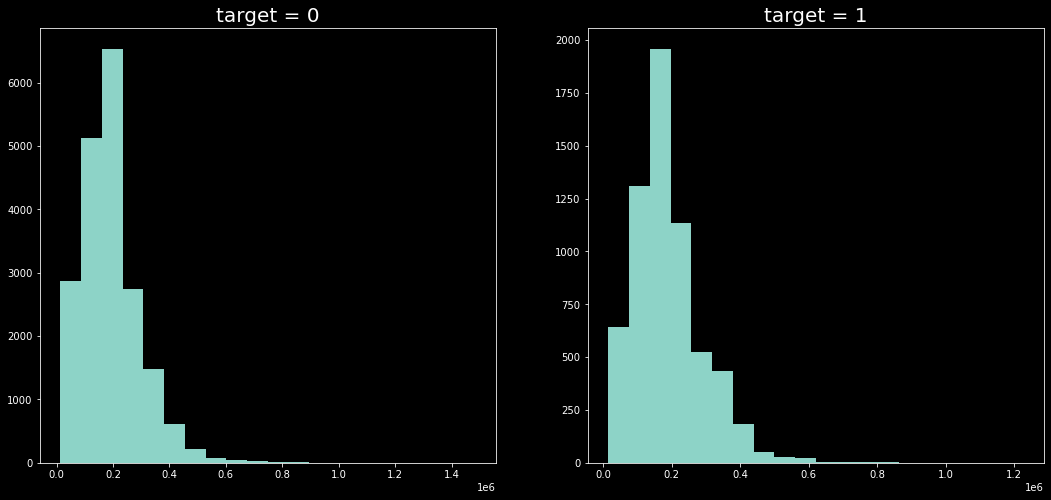

In [101]:
fig, axes = plt.subplots(1,2, figsize=(18,8))
bins = 20
title = ['target = 0', 'target = 1']
for i in range(2):
    ax = axes[i]
    ax.hist(data['fnlwgt'][data['income']==i], bins = bins)
    ax.set_title(title[i],fontsize = 20, color = 'white')

    #xticks 색상 바꾸는 방법.
    plt.sca(ax)
    plt.xticks(color = 'white')

    # 일반적인 방법.
#   plt.xticks(axes = ax,color = 'white')
plt.show()

In [102]:
fnlwgt_1 = data['fnlwgt'][data['income'] == 1]
fnlwgt_0 = data['fnlwgt'][data['income'] == 0]
stats.levene(fnlwgt_1,fnlwgt_0)

LeveneResult(statistic=12.305172775874171, pvalue=0.0004524656839560308)

In [103]:
t_result = stats.ttest_ind(fnlwgt_0,fnlwgt_1, equal_var = False)
t, p = t_result.statistic.round(3), t_result.pvalue.round(3)
print("2-Sample T-test(Welch's T-test) ")
print('t:{}'.format(t))
print('p:{}'.format(p))

2-Sample T-test(Welch's T-test) 
t:1.239
p:0.215


## 등분산성 검정 결과, 5만불이 넘어가는 집단의 fnlwgt와 그렇지 않은 집단 간 분산성이 다르기때문에, Welch's T-test를 진행.
## P > 0.05이므로 두 집단 간 차이가 없다.

<a class="anchor" id="교육수준"></a>
## <center style="background-color:black; width:40%;">소득 별 교육 수준.</center>

In [104]:
data['education'].describe()

count       26049
unique         16
top       HS-grad
freq         8433
Name: education, dtype: object

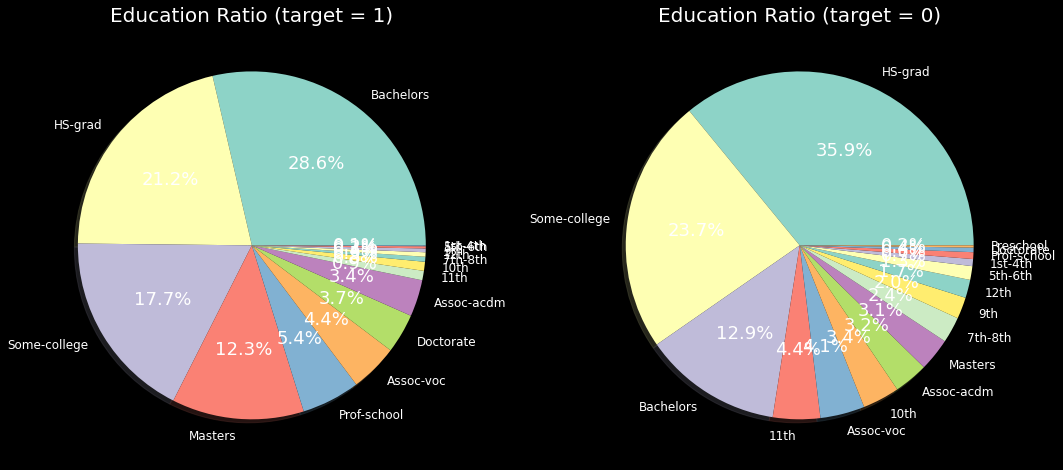

In [105]:
data_1_all = []
data_1 = data['education'][data['income'] == 1]
data_0 = data['education'][data['income'] == 0]
labels = []

data_count_1 = data_1.value_counts()
data_count_0 = data_0.value_counts()
data_1_all.append(data_count_1)
data_1_all.append(data_count_0)
label_1 = data_count_1.index
label_2 = data_count_0.index
labels.append(label_1)
labels.append(label_2)
fig, axes = plt.subplots(1,2, figsize=(18,8))
title = ['Education Ratio (target = 1)','Education Ratio (target = 0)']
for i in range(2):
    ax = axes[i]
    patches, texts, autotexts = ax.pie(data_1_all[i],labels = labels[i], autopct = '%1.1f%%', shadow=True)
    ax.set_title(title[i],color = 'white', fontsize = 20)
    for t in texts:
        t.set_fontsize(12)
        t.set_color('white')

    for t in autotexts:
        t.set_color("white")
        t.set_fontsize(18)
    
plt.show()

In [106]:
data_count_merge = pd.merge(data_count_1,data_count_0, left_index = True, right_index = True, how = 'left')
data_count_merge.rename(columns = {'education_x': 'target_1','education_y':'target_0' }, inplace = True)
data_count_merge

,target_1,target_0
Bachelors,1805,2539
HS-grad,1337,7096
Some-college,1117,4683
Masters,774,604
Prof-school,342,124
Assoc-voc,280,816
Doctorate,232,84
Assoc-acdm,215,627
11th,55,867
10th,53,678


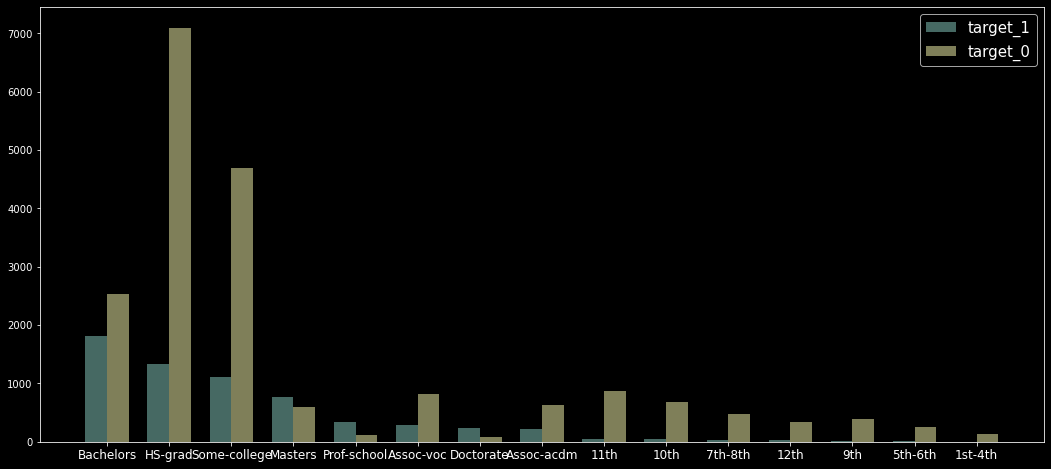

In [107]:
x = np.arange(len(data_count_merge))
fig, ax = plt.subplots(1,1, figsize=(18,8))
ax.bar(x - 0.35/2,data_count_merge['target_1'], 0.35,align='center',alpha=0.5)
ax.bar(x + 0.35/2,data_count_merge['target_0'], 0.35,align='center',alpha=0.5)

plt.xticks(x)
ax.set_xticklabels(data_count_merge.index)
plt.legend(['target_1','target_0'],fontsize=15)
plt.sca(ax)
plt.xticks(color = 'white',fontsize=12)
plt.show()

In [108]:
data['education_num'].value_counts()

9     8433
10    5800
13    4344
14    1378
11    1096
7      922
12     842
6      731
4      505
15     466
5      418
8      359
16     316
3      265
2      134
1       40
Name: education_num, dtype: int64

In [109]:
data_count_all = data.groupby(['education','education_num'])['income'].sum()
data_count_all

education     education_num
10th          6                  53
11th          7                  55
12th          8                  26
1st-4th       2                   5
5th-6th       3                  13
7th-8th       4                  29
9th           5                  22
Assoc-acdm    12                215
Assoc-voc     11                280
Bachelors     13               1805
Doctorate     16                232
HS-grad       9                1337
Masters       14                774
Preschool     1                   0
Prof-school   15                342
Some-college  10               1117
Name: income, dtype: int64

## groupby 결과, education과 education_num이 1:1 맵핑이 된다는 것을 알 수가 있음.

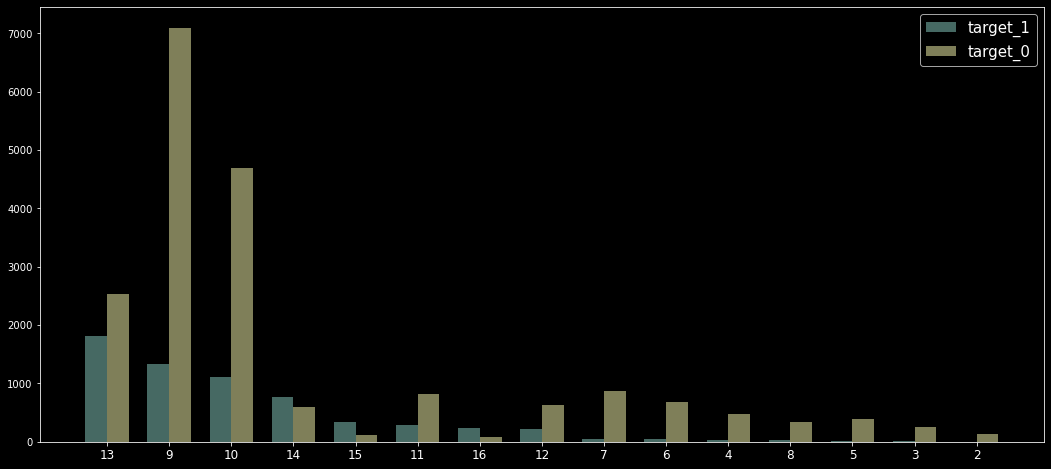

In [110]:
data_1 = data['education_num'][data['income'] == 1]
data_0 = data['education_num'][data['income'] == 0]
data_count_1 = data_1.value_counts()
data_count_0 = data_0.value_counts()
data_count_merge = pd.merge(data_count_1,data_count_0, left_index = True, right_index = True, how = 'left')
data_count_merge.rename(columns = {'education_num_x': 'target_1','education_num_y':'target_0' }, inplace = True)
x = np.arange(len(data_count_merge))
fig, ax = plt.subplots(1,1, figsize=(18,8))
ax.bar(x - 0.35/2,data_count_merge['target_1'], 0.35,align='center',alpha=0.5)
ax.bar(x + 0.35/2,data_count_merge['target_0'], 0.35,align='center',alpha=0.5)

plt.xticks(x)
ax.set_xticklabels(data_count_merge.index)
plt.legend(['target_1','target_0'],fontsize=15)
plt.sca(ax)
plt.xticks(color = 'white',fontsize=12)
plt.show()

<a class="anchor" id="결혼"></a>
## <center style="background-color:black; width:40%;">소득 별 결혼 여부.</center>

In [111]:
data['marital_status'].unique()

array(['Married-civ-spouse', 'Never-married', 'Separated',
       'Married-spouse-absent', 'Divorced', 'Widowed',
       'Married-AF-spouse'], dtype=object)

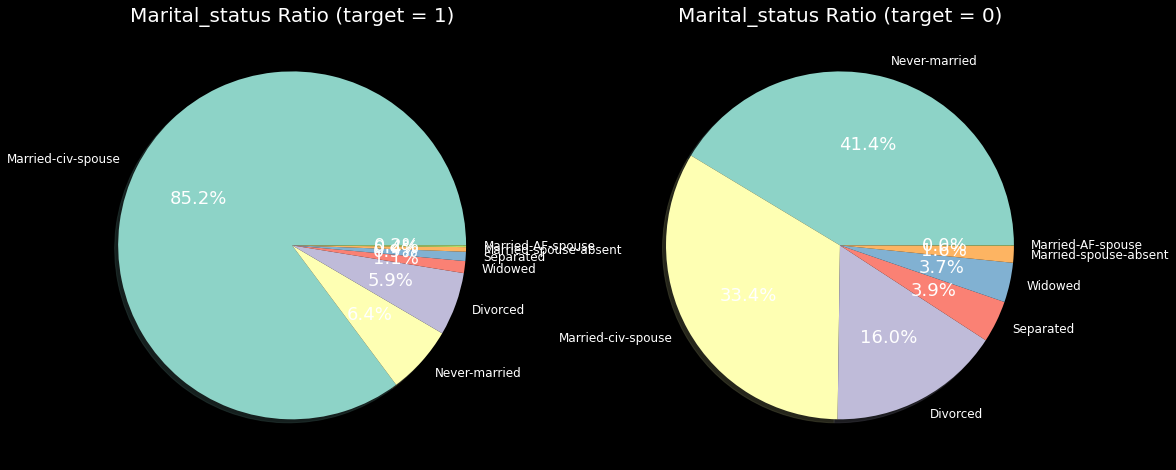

In [112]:
data_count_1 = data['marital_status'][data['income'] == 1].value_counts()
data_count_0 = data['marital_status'][data['income'] == 0].value_counts()

data_1_all = []
labels = []
data_1_all.append(data_count_1)
data_1_all.append(data_count_0)
label_1 = data_count_1.index
label_2 = data_count_0.index
labels.append(label_1)
labels.append(label_2)
fig, axes = plt.subplots(1,2, figsize=(18,8))
title = ['Marital_status Ratio (target = 1)','Marital_status Ratio (target = 0)']
for i in range(2):
    ax = axes[i]
    patches, texts, autotexts = ax.pie(data_1_all[i],labels = labels[i], autopct = '%1.1f%%', shadow=True)
    ax.set_title(title[i],color = 'white', fontsize = 20)
    for t in texts:
        t.set_fontsize(12)
        t.set_color('white')

    for t in autotexts:
        t.set_color("white")
        t.set_fontsize(18)
    
plt.show()

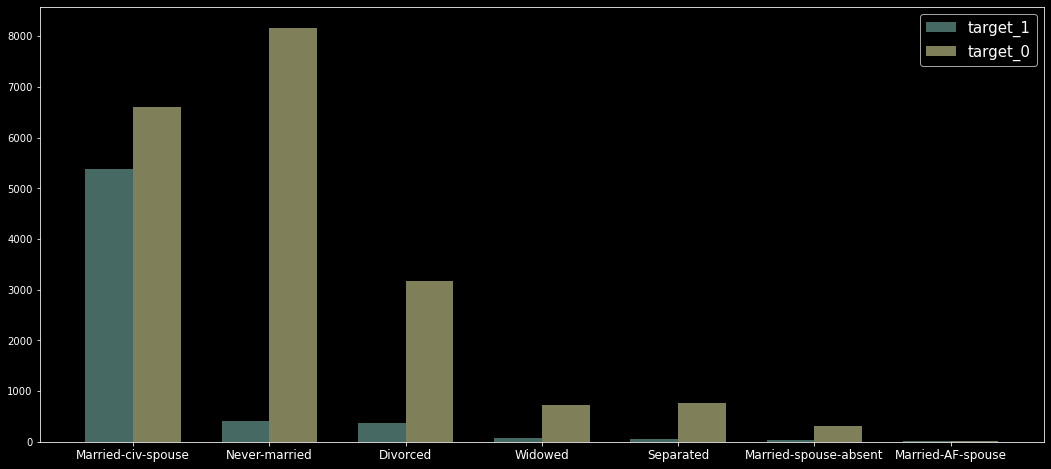

In [113]:
data_count_merge = pd.merge(data_count_1,data_count_0, left_index = True, right_index = True, how = 'left')
data_count_merge.rename(columns = {'marital_status_x': 'target_1','marital_status_y':'target_0' }, inplace = True)
x = np.arange(len(data_count_merge))
fig, ax = plt.subplots(1,1, figsize=(18,8))
ax.bar(x - 0.35/2,data_count_merge['target_1'], 0.35,align='center',alpha=0.5)
ax.bar(x + 0.35/2,data_count_merge['target_0'], 0.35,align='center',alpha=0.5)

plt.xticks(x)
ax.set_xticklabels(data_count_merge.index)
plt.legend(['target_1','target_0'],fontsize=15)
plt.sca(ax)
plt.xticks(color = 'white',fontsize=12)
plt.show()

<a class="anchor" id="업종"></a>
## <center style="background-color:black; width:40%;">소득 별 업종.</center>

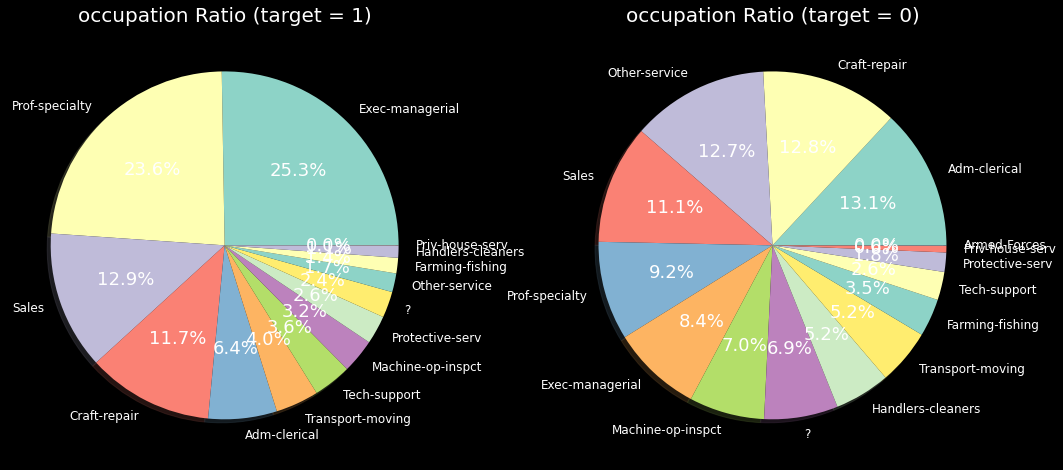

In [114]:
data_count_1 = data['occupation'][data['income'] == 1].value_counts()
data_count_0 = data['occupation'][data['income'] == 0].value_counts()

data_1_all = []
labels = []
data_1_all.append(data_count_1)
data_1_all.append(data_count_0)
label_1 = data_count_1.index
label_2 = data_count_0.index
labels.append(label_1)
labels.append(label_2)
fig, axes = plt.subplots(1,2, figsize=(18,8))
title = ['occupation Ratio (target = 1)','occupation Ratio (target = 0)']
for i in range(2):
    ax = axes[i]
    patches, texts, autotexts = ax.pie(data_1_all[i],labels = labels[i], autopct = '%1.1f%%', shadow=True)
    ax.set_title(title[i],color = 'white', fontsize = 20)
    for t in texts:
        t.set_fontsize(12)
        t.set_color('white')

    for t in autotexts:
        t.set_color("white")
        t.set_fontsize(18)
    
plt.show()

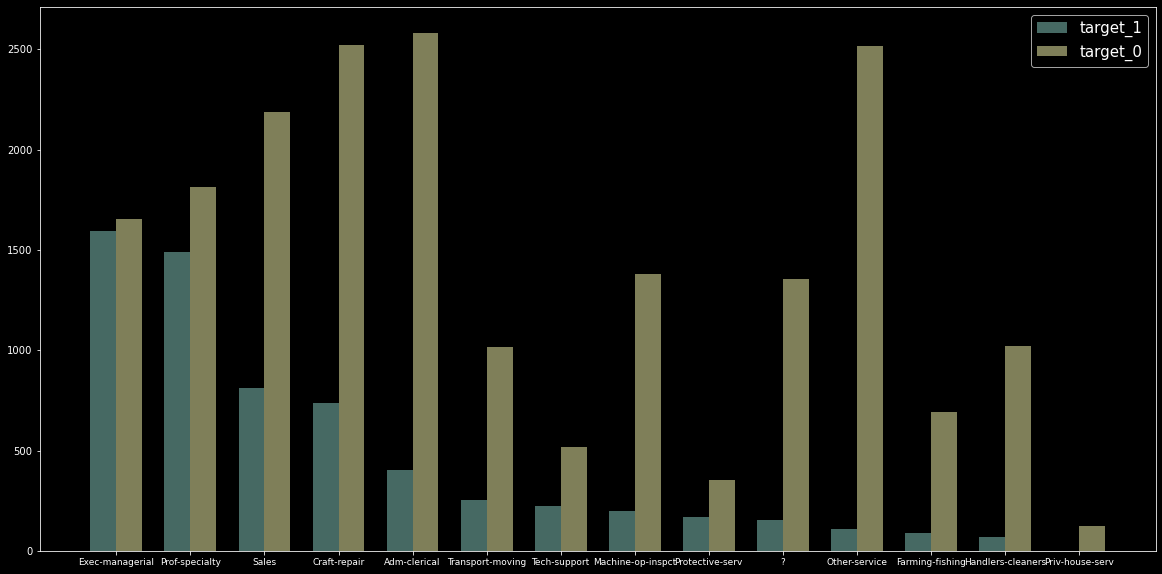

In [115]:
data_count_merge = pd.merge(data_count_1,data_count_0, left_index = True, right_index = True, how = 'left')
data_count_merge.rename(columns = {'occupation_x': 'target_1','occupation_y':'target_0' }, inplace = True)
x = np.arange(len(data_count_merge))
fig, ax = plt.subplots( figsize=(20,10))
ax.bar(x - 0.35/2,data_count_merge['target_1'], 0.35,align='center',alpha=0.5)
ax.bar(x + 0.35/2,data_count_merge['target_0'], 0.35,align='center',alpha=0.5)

plt.xticks(x)
ax.set_xticklabels(data_count_merge.index)
plt.legend(['target_1','target_0'],fontsize=15)
plt.sca(ax)
plt.xticks(color = 'white',fontsize=9)
plt.show()

<a class="anchor" id="가족"></a>
## <center style="background-color:black; width:40%;">소득 별 가족관계.</center>

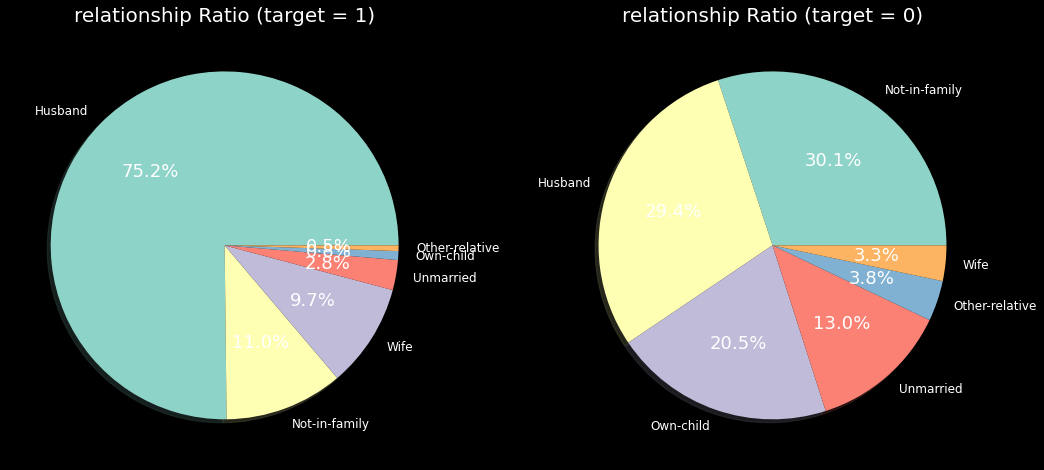

In [116]:
data_count_1 = data['relationship'][data['income'] == 1].value_counts()
data_count_0 = data['relationship'][data['income'] == 0].value_counts()

data_1_all = []
labels = []
data_1_all.append(data_count_1)
data_1_all.append(data_count_0)
label_1 = data_count_1.index
label_2 = data_count_0.index
labels.append(label_1)
labels.append(label_2)
fig, axes = plt.subplots(1,2, figsize=(18,8))
title = ['relationship Ratio (target = 1)','relationship Ratio (target = 0)']
for i in range(2):
    ax = axes[i]
    patches, texts, autotexts = ax.pie(data_1_all[i],labels = labels[i], autopct = '%1.1f%%', shadow=True)
    ax.set_title(title[i],color = 'white', fontsize = 20)
    for t in texts:
        t.set_fontsize(12)
        t.set_color('white')

    for t in autotexts:
        t.set_color("white")
        t.set_fontsize(18)
    
plt.show()

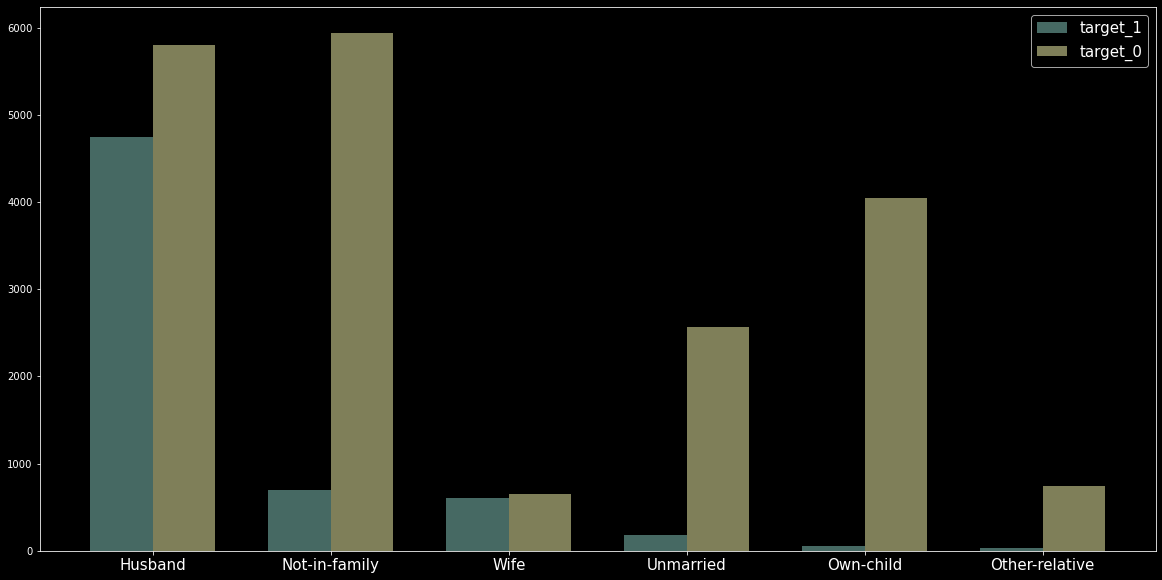

In [117]:
data_count_merge = pd.merge(data_count_1,data_count_0, left_index = True, right_index = True, how = 'left')
data_count_merge.rename(columns = {'relationship_x': 'target_1','relationship_y':'target_0' }, inplace = True)
x = np.arange(len(data_count_merge))
fig, ax = plt.subplots( figsize=(20,10))
ax.bar(x - 0.35/2,data_count_merge['target_1'], 0.35,align='center',alpha=0.5)
ax.bar(x + 0.35/2,data_count_merge['target_0'], 0.35,align='center',alpha=0.5)

plt.xticks(x)
ax.set_xticklabels(data_count_merge.index)
plt.legend(['target_1','target_0'],fontsize=15)
plt.sca(ax)
plt.xticks(color = 'white',fontsize=15)
plt.show()

<a class="anchor" id="인종"></a>
## <center style="background-color:black; width:40%;">소득 별 인종.</center>

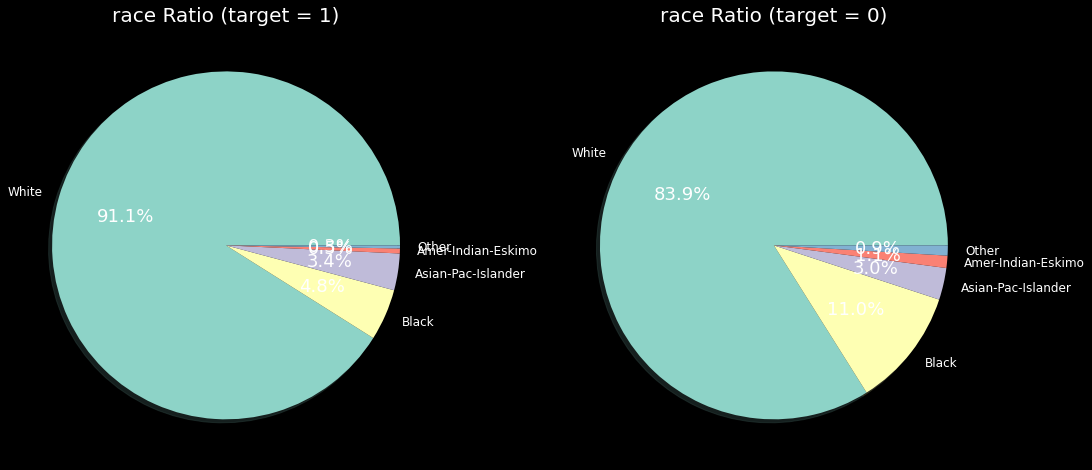

In [118]:
data_count_1 = data['race'][data['income'] == 1].value_counts()
data_count_0 = data['race'][data['income'] == 0].value_counts()

data_1_all = []
labels = []
data_1_all.append(data_count_1)
data_1_all.append(data_count_0)
label_1 = data_count_1.index
label_2 = data_count_0.index
labels.append(label_1)
labels.append(label_2)
fig, axes = plt.subplots(1,2, figsize=(18,8))
title = ['race Ratio (target = 1)','race Ratio (target = 0)']
for i in range(2):
    ax = axes[i]
    patches, texts, autotexts = ax.pie(data_1_all[i],labels = labels[i], autopct = '%1.1f%%', shadow=True)
    ax.set_title(title[i],color = 'white', fontsize = 20)
    for t in texts:
        t.set_fontsize(12)
        t.set_color('white')

    for t in autotexts:
        t.set_color("white")
        t.set_fontsize(18)
    
plt.show()

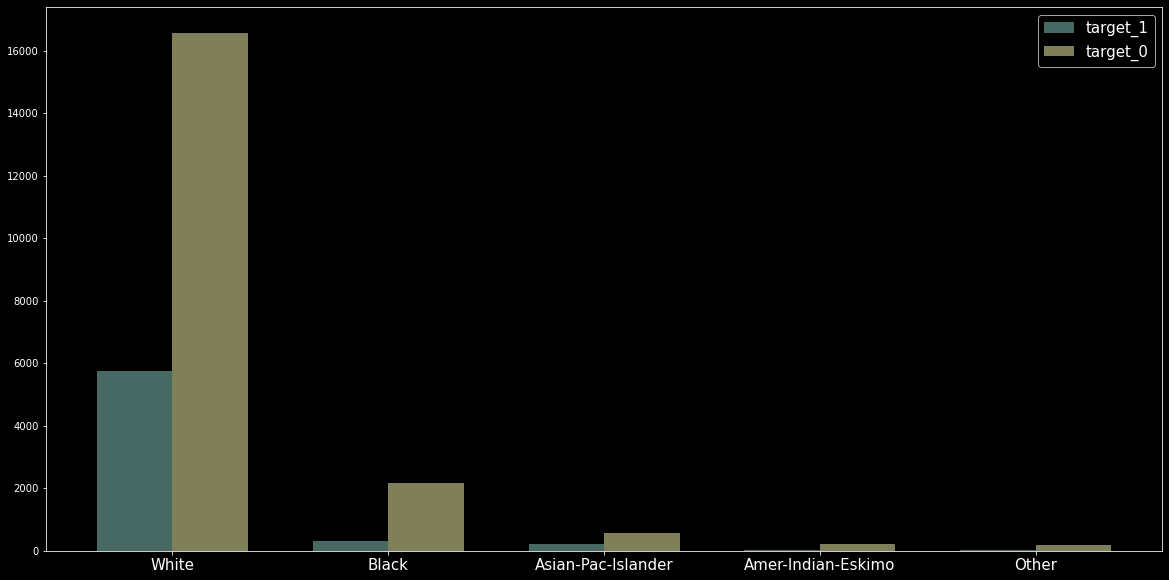

In [119]:
data_count_merge = pd.merge(data_count_1,data_count_0, left_index = True, right_index = True, how = 'left')
data_count_merge.rename(columns = {'race_x': 'target_1','race_y':'target_0' }, inplace = True)
x = np.arange(len(data_count_merge))
fig, ax = plt.subplots( figsize=(20,10))
ax.bar(x - 0.35/2,data_count_merge['target_1'], 0.35,align='center',alpha=0.5)
ax.bar(x + 0.35/2,data_count_merge['target_0'], 0.35,align='center',alpha=0.5)

plt.xticks(x)
ax.set_xticklabels(data_count_merge.index)
plt.legend(['target_1','target_0'],fontsize=15)
plt.sca(ax)
plt.xticks(color = 'white',fontsize=15)
plt.show()

<a class="anchor" id="성별"></a>
## <center style="background-color:black; width:40%;">소득 별 성별.</center>

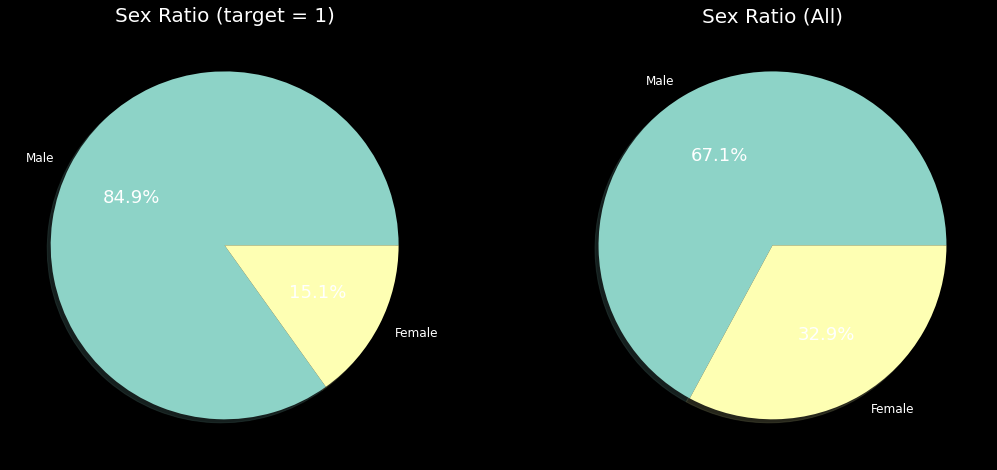

In [120]:
data_count_1 = data['sex'][data['income'] == 1].value_counts()
data_count_0 = data['sex'].value_counts()

data_1_all = []
labels = []
data_1_all.append(data_count_1)
data_1_all.append(data_count_0)
label_1 = data_count_1.index
label_2 = data_count_0.index
labels.append(label_1)
labels.append(label_2)
fig, axes = plt.subplots(1,2, figsize=(18,8))
title = ['Sex Ratio (target = 1)','Sex Ratio (All)']
for i in range(2):
    ax = axes[i]
    patches, texts, autotexts = ax.pie(data_1_all[i],labels = labels[i], autopct = '%1.1f%%', shadow=True)
    ax.set_title(title[i],color = 'white', fontsize = 20)
    for t in texts:
        t.set_fontsize(12)
        t.set_color('white')

    for t in autotexts:
        t.set_color("white")
        t.set_fontsize(18)
    
plt.show()

<a class="anchor" id="파생1"></a>
## <center style="background-color:black; width:60%;">인종 성별 별 소득이 50K가 넘는 비율.</center>

In [121]:
data['income'] = data['income'].astype(int)
data.groupby(['race', 'sex'])[['income']].mean().style.background_gradient(cmap='Purples')

<a class="anchor" id="양도소득"></a>
## <center style="background-color:black; width:40%;">소득 별 양도 소득.</center>

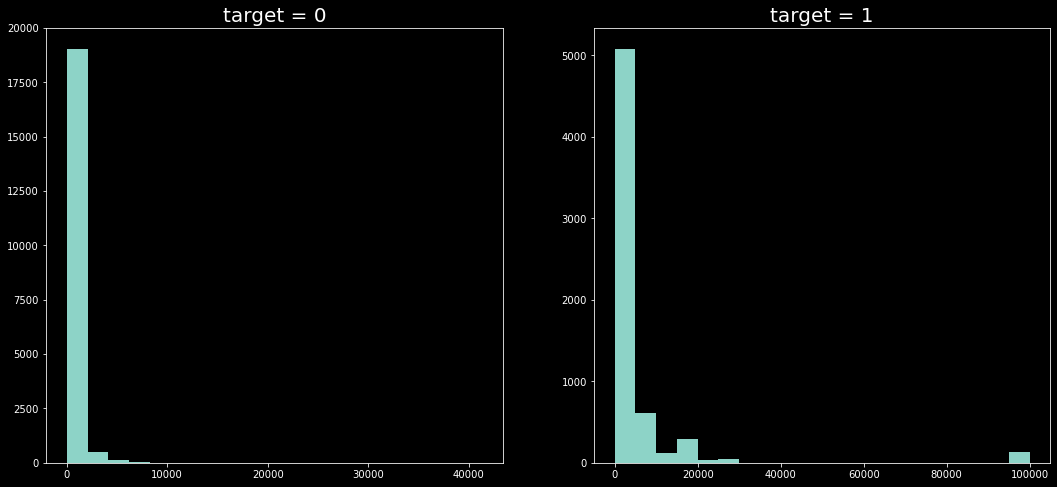

In [122]:
fig, axes = plt.subplots(1,2, figsize=(18,8))
bins = 20
title = ['target = 0', 'target = 1']
for i in range(2):
    ax = axes[i]
    ax.hist(data['capital_gain'][data['income']==i], bins = bins)
    ax.set_title(title[i],fontsize = 20, color = 'white')

    #xticks 색상 바꾸는 방법.
    plt.sca(ax)
    plt.xticks(color = 'white')

    # 일반적인 방법.
#   plt.xticks(axes = ax,color = 'white')
plt.show()

<a class="anchor" id="양도손실"></a>
## <center style="background-color:black; width:40%;">소득 별 양도 손실.</center>

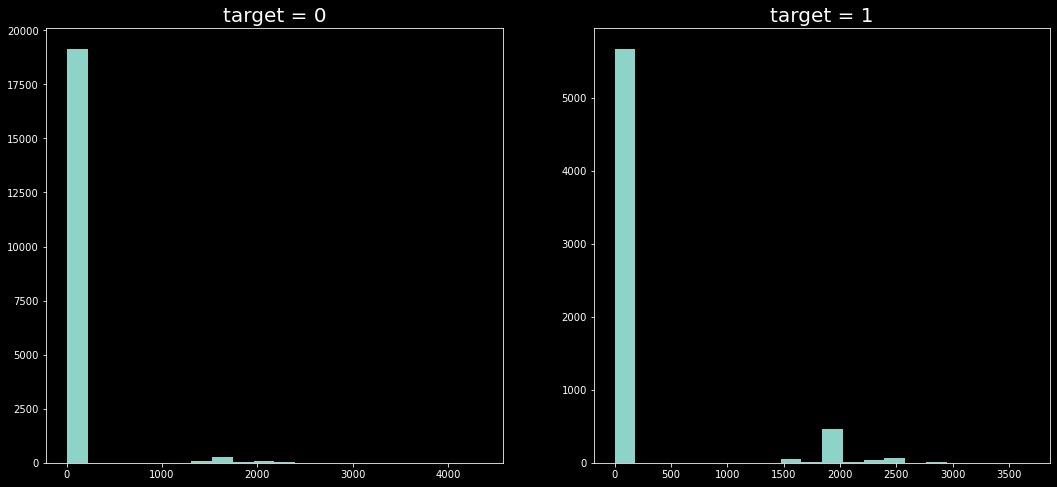

In [123]:
fig, axes = plt.subplots(1,2, figsize=(18,8))
bins = 20
title = ['target = 0', 'target = 1']
for i in range(2):
    ax = axes[i]
    ax.hist(data['capital_loss'][data['income']==i], bins = bins)
    ax.set_title(title[i],fontsize = 20, color = 'white')

    #xticks 색상 바꾸는 방법.
    plt.sca(ax)
    plt.xticks(color = 'white')

    # 일반적인 방법.
#   plt.xticks(axes = ax,color = 'white')
plt.show()

<a class="anchor" id="주당근무시간"></a>
## <center style="background-color:black; width:40%;">소득 별 주당 근무 시간.</center>

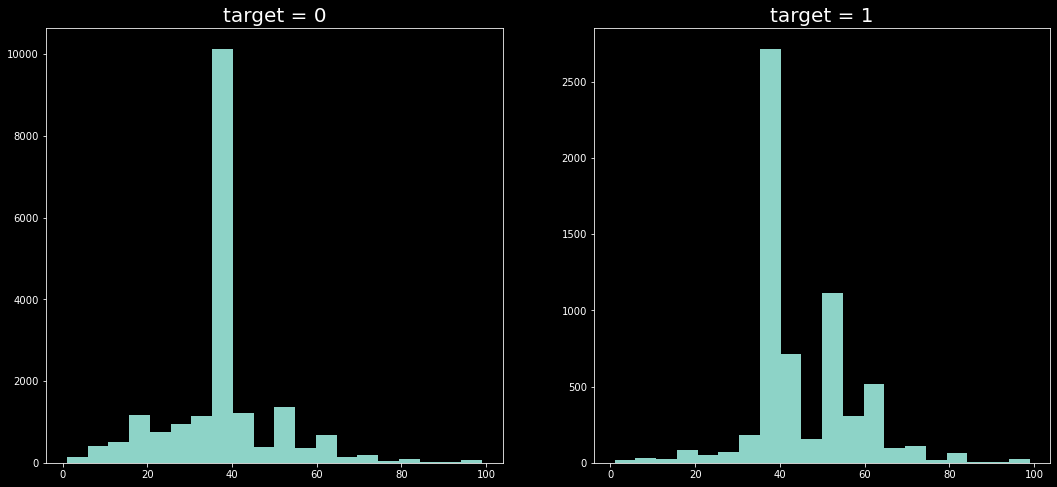

In [124]:
fig, axes = plt.subplots(1,2, figsize=(18,8))
bins = 20
title = ['target = 0', 'target = 1']
for i in range(2):
    ax = axes[i]
    ax.hist(data['hours_per_week'][data['income']==i], bins = bins)
    ax.set_title(title[i],fontsize = 20, color = 'white')

    #xticks 색상 바꾸는 방법.
    plt.sca(ax)
    plt.xticks(color = 'white')

    # 일반적인 방법.
#   plt.xticks(axes = ax,color = 'white')
plt.show()

<a class="anchor" id="국적"></a>
## <center style="background-color:black; width:40%;">소득 별 국적.</center>

In [125]:
data_1 = data['native_country'][data['income']==1]
data_1.value_counts(normalize = True)

United-States         0.916733
?                     0.016971
Philippines           0.007772
Germany               0.005551
India                 0.004917
Canada                0.004600
Mexico                0.004124
England               0.003648
Cuba                  0.003172
Japan                 0.003013
Italy                 0.003013
Taiwan                0.002855
Iran                  0.002696
South                 0.002220
China                 0.002062
Puerto-Rico           0.001745
France                0.001586
Poland                0.001586
Jamaica               0.001110
El-Salvador           0.001110
Cambodia              0.000952
Greece                0.000952
Yugoslavia            0.000793
Ireland               0.000634
Ecuador               0.000634
Vietnam               0.000634
Haiti                 0.000634
Hong                  0.000634
Guatemala             0.000476
Hungary               0.000476
Scotland              0.000317
Dominican-Republic    0.000317
Columbia

In [126]:
data_1 = data['native_country']
data_1.value_counts(normalize = True)

United-States                 0.897194
Mexico                        0.020500
?                             0.017505
Philippines                   0.006257
Germany                       0.003877
Puerto-Rico                   0.003647
Canada                        0.003532
El-Salvador                   0.003033
India                         0.002956
Cuba                          0.002918
England                       0.002572
Jamaica                       0.002457
South                         0.002419
China                         0.002188
Columbia                      0.001996
Guatemala                     0.001996
Vietnam                       0.001919
Italy                         0.001919
Dominican-Republic            0.001843
Japan                         0.001804
Poland                        0.001804
Taiwan                        0.001497
Haiti                         0.001344
Iran                          0.001344
Portugal                      0.001152
Nicaragua                

<a class="anchor" id="상관"></a>
## <center style="background-color:black; width:40%;">수치형 설명변수 간 상관계수.</center>

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text major ticklabel objects>)

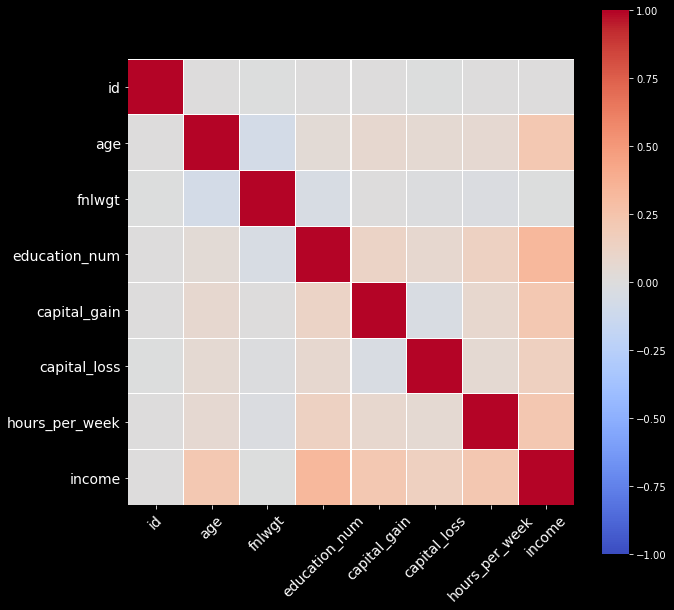

In [127]:
# corr = data.corr().style.background_gradient(cmap = 'coolwarm')
fig, ax = plt.subplots(1,1,figsize=(10,10))
corr = data.corr()
hm = sns.heatmap(corr,square = True,linecolor = 'white', linewidth=0.1,cmap='coolwarm',vmax=1.0, vmin = -1.0)
cb = ax.collections[0].colorbar
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'),color='white')

plt.sca(ax)
plt.xticks(color = 'white', rotation = 45,fontsize = 14)
plt.yticks(color = 'white',fontsize=14)

<a class="anchor" id="결측치_이상치"></a>
## <center style="background-color:black; width:40%;">결측치 및 이상치 도출.</center>

In [128]:
data.sample(10)

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
25613,25613,10,Private,368700,11th,7,Never-married,Sales,Own-child,White,Male,0,0,28,United-States,0
3975,3975,40,Private,378384,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1902,60,United-States,1
14461,14461,40,Private,157249,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Black,Male,0,1977,50,United-States,1
8938,8938,20,Private,260254,HS-grad,9,Never-married,Sales,Own-child,White,Male,0,0,40,United-States,0
6815,6815,20,Private,227332,Bachelors,13,Never-married,Transport-moving,Unmarried,Asian-Pac-Islander,Male,0,0,40,?,0
20476,20476,40,Private,34007,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,1
7461,7461,50,Private,163708,HS-grad,9,Widowed,Other-service,Unmarried,White,Female,0,0,40,United-States,0
13808,13808,20,Self-emp-not-inc,184710,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
9584,9584,50,Self-emp-inc,108435,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,United-States,1
11361,11361,30,State-gov,37070,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,Canada,0


In [129]:
data.describe()

,id,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income
count,26049.000000,26049.000000,2.604900e+04,26049.000000,26049.00000,26049.000000,26049.000000,26049.000000
mean,13024.000000,34.091904,1.903045e+05,10.088372,1087.68970,87.732734,40.443126,0.242044
std,7519.842917,14.034148,1.059663e+05,2.567610,7388.85469,403.230205,12.361850,0.428329
min,0.000000,10.000000,1.376900e+04,1.000000,0.00000,0.000000,1.000000,0.000000
25%,6512.000000,20.000000,1.181080e+05,9.000000,0.00000,0.000000,40.000000,0.000000
50%,13024.000000,30.000000,1.788660e+05,10.000000,0.00000,0.000000,40.000000,0.000000
75%,19536.000000,40.000000,2.377350e+05,12.000000,0.00000,0.000000,45.000000,0.000000
max,26048.000000,90.000000,1.484705e+06,16.000000,99999.00000,4356.000000,99.000000,1.000000


In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26049 entries, 0 to 26048
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              26049 non-null  int64 
 1   age             26049 non-null  int64 
 2   workclass       26049 non-null  object
 3   fnlwgt          26049 non-null  int64 
 4   education       26049 non-null  object
 5   education_num   26049 non-null  int64 
 6   marital_status  26049 non-null  object
 7   occupation      26049 non-null  object
 8   relationship    26049 non-null  object
 9   race            26049 non-null  object
 10  sex             26049 non-null  object
 11  capital_gain    26049 non-null  int64 
 12  capital_loss    26049 non-null  int64 
 13  hours_per_week  26049 non-null  int64 
 14  native_country  26049 non-null  object
 15  income          26049 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 3.2+ MB


In [131]:
data.isna().sum()

id                0
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [132]:
c2 = 'red'
data = origin_data.copy()
box_data = data[['fnlwgt','age','capital_gain','capital_loss']]
box_data

,fnlwgt,age,capital_gain,capital_loss
0,168538,40,0,0
1,101626,17,0,0
2,353358,18,0,0
3,151158,21,0,0
4,122234,24,0,0
...,...,...,...,...
26044,250201,57,0,0
26045,238092,23,0,0
26046,165694,78,0,0
26047,151626,26,0,0


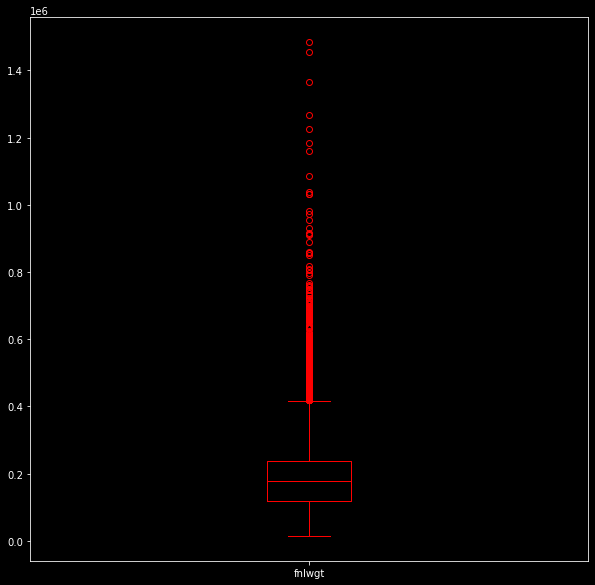

In [133]:
fig, ax = plt.subplots(figsize = (10,10))
ax = plt.boxplot([box_data['fnlwgt']])
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(ax[item], color=c2)
# plt.setp(ax["boxes"], facecolor=c2)
plt.setp(ax["fliers"], markeredgecolor=c2)
plt.xticks([1], ['fnlwgt'])
plt.show()

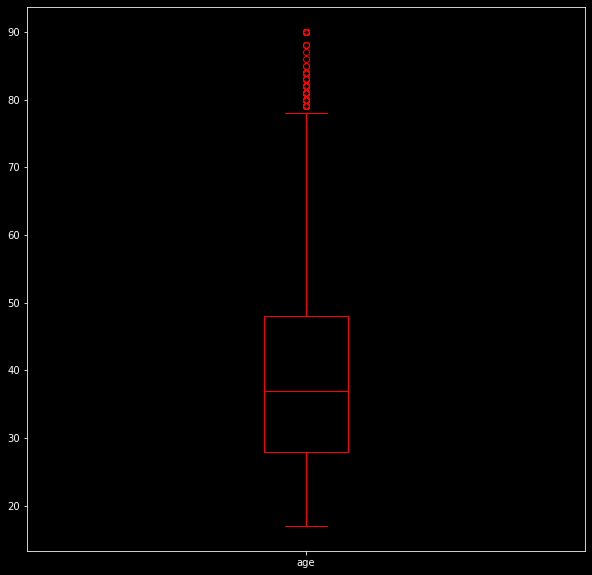

In [134]:
fig, ax = plt.subplots(figsize = (10,10))
ax = plt.boxplot([box_data['age']])
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(ax[item], color=c2)
# plt.setp(ax["boxes"], facecolor=c2)
plt.setp(ax["fliers"], markeredgecolor=c2)
plt.xticks([1], ['age'])
plt.show()

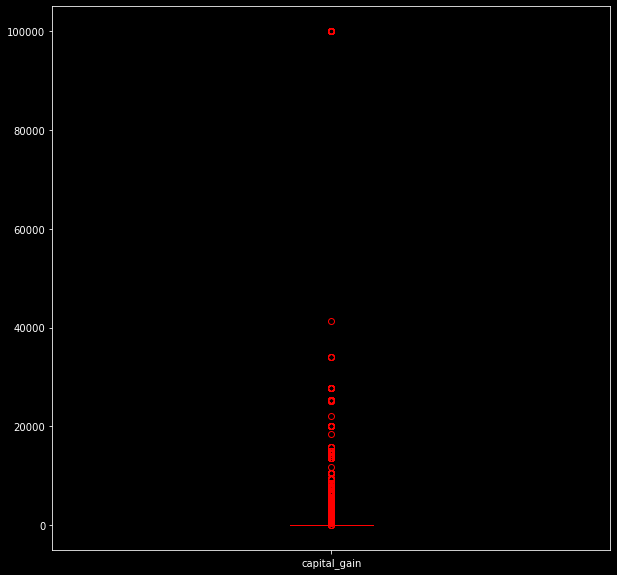

In [135]:
fig, ax = plt.subplots(figsize = (10,10))
ax = plt.boxplot([box_data['capital_gain']])
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(ax[item], color=c2)
# plt.setp(ax["boxes"], facecolor=c2)
plt.setp(ax["fliers"], markeredgecolor=c2)
plt.xticks([1], ['capital_gain'])
plt.show()

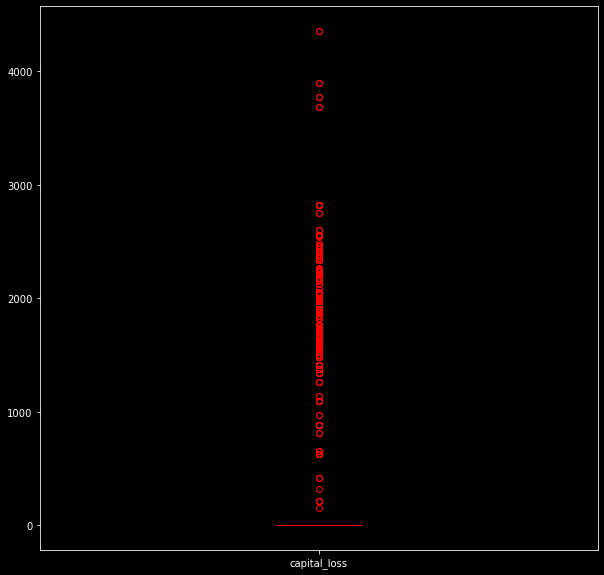

In [136]:
fig, ax = plt.subplots(figsize = (10,10))
ax = plt.boxplot([box_data['capital_loss']])
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(ax[item], color=c2)
# plt.setp(ax["boxes"], facecolor=c2)
plt.setp(ax["fliers"], markeredgecolor=c2)
plt.xticks([1], ['capital_loss'])
plt.show()

In [137]:
data['capital_gain'][data['capital_gain'] == 99999].count()

127

In [138]:
data['income'][data['capital_gain'] == 99999].sum()

127

In [139]:
data[data.apply(lambda x : "?" in list(x), axis = 1)]

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
4,4,24,Private,122234,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,?,0
11,11,21,?,204226,Some-college,10,Never-married,?,Unmarried,White,Female,0,0,35,United-States,0
30,30,20,?,202994,Some-college,10,Never-married,?,Own-child,White,Female,0,0,16,United-States,0
34,34,31,?,505438,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,30,Mexico,0
66,66,67,?,39100,HS-grad,9,Married-civ-spouse,?,Wife,White,Female,0,0,5,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26009,26009,73,?,89852,1st-4th,2,Married-civ-spouse,?,Husband,White,Male,0,0,40,Portugal,0
26010,26010,63,?,321403,9th,5,Separated,?,Not-in-family,Black,Male,0,0,40,United-States,0
26012,26012,36,?,214896,9th,5,Divorced,?,Unmarried,White,Female,0,0,40,Mexico,0
26046,26046,78,?,165694,Masters,14,Widowed,?,Not-in-family,White,Female,0,0,15,United-States,0


In [140]:
data['workclass'].value_counts()

Private             18123
Self-emp-not-inc     2030
Local-gov            1692
?                    1502
State-gov            1043
Self-emp-inc          877
Federal-gov           765
Without-pay            11
Never-worked            6
Name: workclass, dtype: int64

In [141]:
data['occupation'].value_counts()

Prof-specialty       3304
Craft-repair         3262
Exec-managerial      3246
Sales                2998
Adm-clerical         2983
Other-service        2626
Machine-op-inspct    1582
?                    1508
Transport-moving     1270
Handlers-cleaners    1092
Farming-fishing       784
Tech-support          742
Protective-serv       522
Priv-house-serv       123
Armed-Forces            7
Name: occupation, dtype: int64

In [142]:
data[(data['workclass'] == '?') & (data['occupation'] == '?')]

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
11,11,21,?,204226,Some-college,10,Never-married,?,Unmarried,White,Female,0,0,35,United-States,0
30,30,20,?,202994,Some-college,10,Never-married,?,Own-child,White,Female,0,0,16,United-States,0
34,34,31,?,505438,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,30,Mexico,0
66,66,67,?,39100,HS-grad,9,Married-civ-spouse,?,Wife,White,Female,0,0,5,United-States,0
67,67,65,?,404601,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,2414,0,30,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26009,26009,73,?,89852,1st-4th,2,Married-civ-spouse,?,Husband,White,Male,0,0,40,Portugal,0
26010,26010,63,?,321403,9th,5,Separated,?,Not-in-family,Black,Male,0,0,40,United-States,0
26012,26012,36,?,214896,9th,5,Divorced,?,Unmarried,White,Female,0,0,40,Mexico,0
26046,26046,78,?,165694,Masters,14,Widowed,?,Not-in-family,White,Female,0,0,15,United-States,0


In [143]:
data[(data['workclass'] != '?') & (data['occupation'] == '?')]

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
7929,7929,17,Never-worked,237272,10th,6,Never-married,?,Own-child,White,Male,0,0,30,United-States,0
8698,8698,18,Never-worked,157131,11th,7,Never-married,?,Own-child,White,Female,0,0,10,United-States,0
13008,13008,18,Never-worked,153663,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,0
15076,15076,20,Never-worked,462294,Some-college,10,Never-married,?,Own-child,Black,Male,0,0,40,United-States,0
17531,17531,18,Never-worked,206359,10th,6,Never-married,?,Own-child,White,Male,0,0,40,United-States,0
24153,24153,23,Never-worked,188535,7th-8th,4,Divorced,?,Not-in-family,White,Male,0,0,35,United-States,0


In [144]:
data[(data['workclass'] == '?') & (data['occupation'] != '?')]

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income


In [145]:
data.native_country.value_counts()

United-States                 23371
Mexico                          534
?                               456
Philippines                     163
Germany                         101
Puerto-Rico                      95
Canada                           92
El-Salvador                      79
India                            77
Cuba                             76
England                          67
Jamaica                          64
South                            63
China                            57
Columbia                         52
Guatemala                        52
Vietnam                          50
Italy                            50
Dominican-Republic               48
Japan                            47
Poland                           47
Taiwan                           39
Haiti                            35
Iran                             35
Portugal                         30
Nicaragua                        28
Peru                             26
France                      

## 스케일링

In [146]:
data = origin_data.copy()
data.describe()

,id,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,26049.000000,26049.000000,2.604900e+04,26049.000000,26049.00000,26049.000000,26049.000000
mean,13024.000000,38.569235,1.903045e+05,10.088372,1087.68970,87.732734,40.443126
std,7519.842917,13.671489,1.059663e+05,2.567610,7388.85469,403.230205,12.361850
min,0.000000,17.000000,1.376900e+04,1.000000,0.00000,0.000000,1.000000
25%,6512.000000,28.000000,1.181080e+05,9.000000,0.00000,0.000000,40.000000
50%,13024.000000,37.000000,1.788660e+05,10.000000,0.00000,0.000000,40.000000
75%,19536.000000,48.000000,2.377350e+05,12.000000,0.00000,0.000000,45.000000
max,26048.000000,90.000000,1.484705e+06,16.000000,99999.00000,4356.000000,99.000000


In [147]:
data.head()

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,40,Private,168538,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,1
1,1,17,Private,101626,9th,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States,0
2,2,18,Private,353358,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,0
3,3,21,Private,151158,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,United-States,0
4,4,24,Private,122234,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,?,0



<a class="anchor" id="데이터_분류"></a>
## <center style="background-color:black; width:40%;">데이터 인코딩 및 검증데이터셋 분류.</center>

1. income 분리
2. id 제거
3. eucation 컬럼 제거
4. fnlwgt 제거
5. occupation의 ?를 unknown으로 변환
6. age min-max 스케일링
7. capital_gain log화 후 min_max 스케일링
8. capital_loss log화 후 스케일링
9. hours_per_week min-max 스케일링
11. workclass 원-핫 인코딩
12. marital_status 원-핫 인코딩 
13. relationship 원-핫 인코딩
14. race 원-핫 인코딩
15. native_country 원-핫 인코딩 

In [157]:
def prepro(data):
    mm_scaler1 = MinMaxScaler()
    mm_scaler2 = MinMaxScaler()
    mm_scaler3 = MinMaxScaler()
    mm_scaler4 = MinMaxScaler()
    data_y = data['income']
    data_x = data.drop('income',axis = 1, inplace = False)
    data_x.drop(['id','fnlwgt','education'],axis = 1, inplace = True)
    
    data['log_capital_gain'] = data['capital_gain'].map(lambda x : np.log(x, where=(x!=0)))
    data['log_capital_loss'] = data['capital_loss'].map(lambda x : np.log(x, where=(x!=0)))

    
    data_x['occupation'][data['occupation'] =='?'] = 'Unknown'
    data_x['native_country'][data['native_country'] =='?'] = 'unknown_country'
    data_x['workclass'][data['workclass'] =='?'] = 'unknown_workclass'
    
    mm_scaler1.fit(data_x['age'].values.reshape(-1,1))
    data_x['mm_age'] = mm_scaler1.transform(data_x['age'].values.reshape(-1,1))

    mm_scaler2.fit(data['log_capital_gain'].values.reshape(-1,1))
    data_x['mm_capital_gain'] = mm_scaler2.transform(data['log_capital_gain'].values.reshape(-1,1))
    
    mm_scaler3.fit(data['log_capital_loss'].values.reshape(-1,1))
    data_x['mm_capital_loss'] = mm_scaler3.transform(data['log_capital_loss'].values.reshape(-1,1))
    
    mm_scaler4.fit(data_x['hours_per_week'].values.reshape(-1,1))
    data_x['mm_hours_per_week'] = mm_scaler4.transform(data_x['hours_per_week'].values.reshape(-1,1))
    data_x.drop(['age','capital_gain','capital_loss','hours_per_week'], axis = 1, inplace = True)
    
    cols = ['workclass', 'occupation', 'marital_status','relationship','race','native_country','sex']
    
    for col in cols:
        data_dummy = pd.get_dummies(data_x[col])
        data_x = pd.concat([data_x, data_dummy], axis = 1)
        data_x.drop([col] ,axis = 1, inplace = True)
    data_x.astype(int)
    data_y.astype(int)
    
    return data_x, data_y, mm_scaler1, mm_scaler2, mm_scaler3, mm_scaler4

data_x, data_y, mm_scaler1, mm_scaler2, mm_scaler3, mm_scaler4 = prepro(data)
data_x.describe()

,education_num,mm_age,mm_capital_gain,mm_capital_loss,mm_hours_per_week,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,...,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,unknown_country,Female,Male
count,26049.000000,26049.000000,26049.000000,26049.000000,26049.000000,26049.000000,26049.000000,26049.000000,26049.000000,26049.000000,...,26049.000000,26049.000000,26049.000000,26049.000000,26049.000000,26049.000000,26049.000000,26049.000000,26049.000000,26049.000000
mean,10.088372,0.295469,0.064561,0.042147,0.402481,0.029368,0.064955,0.000230,0.695727,0.033667,...,0.002419,0.001497,0.000499,0.000537,0.897194,0.001919,0.000461,0.017505,0.328880,0.671120
std,2.567610,0.187281,0.214434,0.189775,0.126141,0.168838,0.246450,0.015175,0.460108,0.180375,...,0.049120,0.038665,0.022334,0.023177,0.303711,0.043770,0.021459,0.131148,0.469815,0.469815
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.150685,0.000000,0.000000,0.397959,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,0.273973,0.000000,0.000000,0.397959,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,12.000000,0.424658,0.000000,0.000000,0.448980,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [158]:
def testprepro(data,mm_scaler1, mm_scaler2, mm_scaler3, mm_scaler4):

    data_y = data['income']
    data_x = data.drop('income',axis = 1, inplace = False)
    data_x.drop(['id','fnlwgt','education'],axis = 1, inplace = True)
    
    data['log_capital_gain'] = data['capital_gain'].map(lambda x : np.log(x, where=(x!=0)))
    data['log_capital_loss'] = data['capital_loss'].map(lambda x : np.log(x, where=(x!=0)))

    
    data_x['occupation'][data['occupation'] =='?'] = 'Unknown'
    data_x['native_country'][data['native_country'] =='?'] = 'unknown_country'
    data_x['workclass'][data['workclass'] =='?'] = 'unknown_workclass'
    data_x['mm_age'] = mm_scaler1.transform(data_x['age'].values.reshape(-1,1))

    data_x['mm_capital_gain'] = mm_scaler2.transform(data['log_capital_gain'].values.reshape(-1,1))
    data_x['mm_capital_loss'] = mm_scaler3.transform(data['log_capital_loss'].values.reshape(-1,1))
    
    data_x['mm_hours_per_week'] = mm_scaler4.transform(data_x['hours_per_week'].values.reshape(-1,1))
    data_x.drop(['age','capital_gain','capital_loss','hours_per_week'], axis = 1, inplace = True)
    
    cols = ['workclass', 'occupation', 'marital_status','relationship','race','native_country','sex']
    
    for col in cols:
        data_dummy = pd.get_dummies(data_x[col])
        data_x = pd.concat([data_x, data_dummy], axis = 1)
        data_x.drop([col] ,axis = 1, inplace = True)
    data_x.astype(int)
    data_y.astype(int)
    return data_x, data_y

In [159]:
data = origin_data.copy()
df_train, df_val = train_test_split(data,test_size = 0.3, random_state = 1234)
df_train_x, df_train_y, mm_scaler1, mm_scaler2, mm_scaler3, mm_scaler4 = prepro(df_train)
df_val_x, df_val_y = testprepro(df_val, mm_scaler1, mm_scaler2, mm_scaler3, mm_scaler4)

In [160]:
df_train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18234 entries, 23632 to 25299
Data columns (total 90 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   education_num               18234 non-null  int64  
 1   mm_age                      18234 non-null  float64
 2   mm_capital_gain             18234 non-null  float64
 3   mm_capital_loss             18234 non-null  float64
 4   mm_hours_per_week           18234 non-null  float64
 5   Federal-gov                 18234 non-null  uint8  
 6   Local-gov                   18234 non-null  uint8  
 7   Never-worked                18234 non-null  uint8  
 8   Private                     18234 non-null  uint8  
 9   Self-emp-inc                18234 non-null  uint8  
 10  Self-emp-not-inc            18234 non-null  uint8  
 11  State-gov                   18234 non-null  uint8  
 12  Without-pay                 18234 non-null  uint8  
 13  unknown_workclass          

In [161]:
df_train_y.describe()

count     18234
unique        2
top           0
freq      13846
Name: income, dtype: int64

In [162]:
df_val_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7815 entries, 16141 to 6154
Data columns (total 90 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   education_num               7815 non-null   int64  
 1   mm_age                      7815 non-null   float64
 2   mm_capital_gain             7815 non-null   float64
 3   mm_capital_loss             7815 non-null   float64
 4   mm_hours_per_week           7815 non-null   float64
 5   Federal-gov                 7815 non-null   uint8  
 6   Local-gov                   7815 non-null   uint8  
 7   Never-worked                7815 non-null   uint8  
 8   Private                     7815 non-null   uint8  
 9   Self-emp-inc                7815 non-null   uint8  
 10  Self-emp-not-inc            7815 non-null   uint8  
 11  State-gov                   7815 non-null   uint8  
 12  Without-pay                 7815 non-null   uint8  
 13  unknown_workclass           7

In [163]:
df_train_y = df_train_y.array
df_val_y = df_val_y.array
df_train_y = df_train_y.to_numpy()
df_val_y = df_val_y.to_numpy()
df_train_y = df_train_y.astype(np.int)
df_val_y = df_val_y.astype(np.int)

In [164]:
type(df_train_y[0])

numpy.int64

In [165]:
df_train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18234 entries, 23632 to 25299
Data columns (total 90 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   education_num               18234 non-null  int64  
 1   mm_age                      18234 non-null  float64
 2   mm_capital_gain             18234 non-null  float64
 3   mm_capital_loss             18234 non-null  float64
 4   mm_hours_per_week           18234 non-null  float64
 5   Federal-gov                 18234 non-null  uint8  
 6   Local-gov                   18234 non-null  uint8  
 7   Never-worked                18234 non-null  uint8  
 8   Private                     18234 non-null  uint8  
 9   Self-emp-inc                18234 non-null  uint8  
 10  Self-emp-not-inc            18234 non-null  uint8  
 11  State-gov                   18234 non-null  uint8  
 12  Without-pay                 18234 non-null  uint8  
 13  unknown_workclass          

<a class="anchor" id="XGBOOST"></a>
## <center style="background-color:black; width:40%;">XGBOOST.</center>

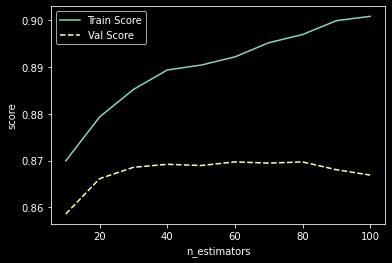

In [166]:
train_score = []; val_score = [] 
para_n_tree = [n_tree *10 for n_tree in range(1,11)]
for v_n_estimators in para_n_tree:
    xgb = XGBClassifier(n_estimators = v_n_estimators, random_state = 1234) 
    xgb.fit(df_train_x, df_train_y)
    train_pred = xgb.predict(df_train_x)
    val_pred = xgb.predict(df_val_x)
    accuracy_score(df_train_y,train_pred)
    train_score.append(accuracy_score(df_train_y,train_pred))
    val_score.append(accuracy_score(df_val_y,val_pred))
#     train_score.append(xgb.score(df_train_x, df_train_y)) 
#     val_score.append(xgb.score(df_val_x, df_val_y))
    
df_score_n= pd.DataFrame() 
df_score_n["n_estimators"] = para_n_tree 
df_score_n["TrainScore"] = train_score 
df_score_n["TestScore"] = val_score

df_score_n.round(3)
plt.plot(para_n_tree, train_score, linestyle ='-', label = "Train Score")
plt.plot(para_n_tree, val_score, linestyle ='--', label = "Val Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

In [167]:
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.870,0.859
1,20,0.879,0.866
2,30,0.885,0.869
3,40,0.889,0.869
4,50,0.890,0.869
5,60,0.892,0.870
6,70,0.895,0.869
7,80,0.897,0.870
8,90,0.900,0.868
9,100,0.901,0.867


In [168]:
train_score = []; val_score = [] 
para_lr = [lr *0.1 for lr in range(1,10)]
for v_learning_rate in para_lr:
    xgb = XGBClassifier(n_estimators = 80, learning_rate = v_learning_rate, random_state = 1234) 
    xgb.fit(df_train_x, df_train_y)
    train_pred = xgb.predict(df_train_x)
    val_pred = xgb.predict(df_val_x)
    accuracy_score(df_train_y,train_pred)
    train_score.append(accuracy_score(df_train_y,train_pred))
    val_score.append(accuracy_score(df_val_y,val_pred))
#     train_score.append(xgb.score(df_train_x, df_train_y)) 
#     val_score.append(xgb.score(df_val_x, df_val_y))
    
df_score_n= pd.DataFrame() 
df_score_n["Learningrate"] = para_lr 
df_score_n["TrainScore"] = train_score 
df_score_n["ValScore"] = val_score

df_score_n.round(3)

,Learningrate,TrainScore,ValScore
0,0.1,0.883,0.868
1,0.2,0.891,0.868
2,0.3,0.897,0.870
3,0.4,0.903,0.865
4,0.5,0.910,0.866
5,0.6,0.912,0.863
6,0.7,0.918,0.860
7,0.8,0.922,0.857
8,0.9,0.922,0.857


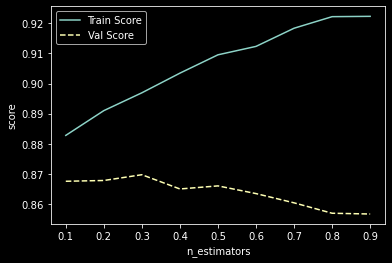

In [169]:
plt.plot(para_lr, train_score, linestyle ='-', label = "Train Score")
plt.plot(para_lr, val_score, linestyle ='--', label = "Val Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

In [170]:
train_score = []; val_score = [] 
para_depth = [depth for depth in range(1,20)]
for v_max_depth in para_depth:
    xgb = XGBClassifier(n_estimators = 80, 
                        learning_rate = 0.3,
                        max_depth = v_max_depth,
                        random_state = 1234) 
    xgb.fit(df_train_x, df_train_y)
    train_pred = xgb.predict(df_train_x)
    val_pred = xgb.predict(df_val_x)
    accuracy_score(df_train_y,train_pred)
    train_score.append(accuracy_score(df_train_y,train_pred))
    val_score.append(accuracy_score(df_val_y,val_pred))
#     train_score.append(xgb.score(df_train_x, df_train_y)) 
#     val_score.append(xgb.score(df_val_x, df_val_y))
    
df_score_n= pd.DataFrame() 
df_score_n["depth"] = para_depth 
df_score_n["TrainScore"] = train_score 
df_score_n["ValScore"] = val_score

df_score_n.round(3)

,depth,TrainScore,ValScore
0,1,0.859,0.853
1,2,0.869,0.861
2,3,0.879,0.869
3,4,0.885,0.870
4,5,0.891,0.867
5,6,0.897,0.870
6,7,0.904,0.867
7,8,0.910,0.866
8,9,0.918,0.864
9,10,0.924,0.863


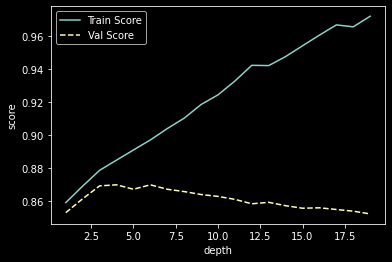

In [171]:
plt.plot(para_depth, train_score, linestyle ='-', label = "Train Score")
plt.plot(para_depth, val_score, linestyle ='--', label = "Val Score")
plt.ylabel("score"); plt.xlabel("depth")
plt.legend()

In [172]:
train_score = []; val_score = [] 
para_child_weight = [child_weight for child_weight in range(1,20)]
for v_min_child_weight in para_child_weight:
    xgb = XGBClassifier(n_estimators = 80, 
                        learning_rate = 0.3,
                        max_depth = 6,
                        min_child_weight = v_min_child_weight,
                        random_state = 1234) 
    xgb.fit(df_train_x, df_train_y)
    train_pred = xgb.predict(df_train_x)
    val_pred = xgb.predict(df_val_x)
    accuracy_score(df_train_y,train_pred)
    train_score.append(accuracy_score(df_train_y,train_pred))
    val_score.append(accuracy_score(df_val_y,val_pred))
#     train_score.append(xgb.score(df_train_x, df_train_y)) 
#     val_score.append(xgb.score(df_val_x, df_val_y))
    
df_score_n= pd.DataFrame() 
df_score_n["min_child_weight"] = para_child_weight
df_score_n["TrainScore"] = train_score 
df_score_n["ValScore"] = val_score

df_score_n.round(3)

,min_child_weight,TrainScore,ValScore
0,1,0.897,0.870
1,2,0.895,0.869
2,3,0.895,0.868
3,4,0.893,0.869
4,5,0.891,0.869
5,6,0.889,0.867
6,7,0.887,0.870
7,8,0.887,0.869
8,9,0.884,0.872
9,10,0.885,0.869


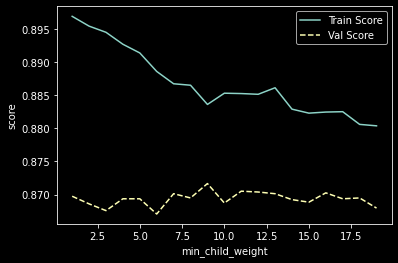

In [173]:
plt.plot(para_child_weight, train_score, linestyle ='-', label = "Train Score")
plt.plot(para_child_weight, val_score, linestyle ='--', label = "Val Score")
plt.ylabel("score"); plt.xlabel("min_child_weight")
plt.legend()

In [174]:
train_score = []; val_score = [] 
para_gamma = [10**gamma for gamma in range(-2,2)] #[0.01,0.1,1,10]
for v_gamma in para_gamma:
    xgb = XGBClassifier(n_estimators = 80, 
                        learning_rate = 0.3,
                        max_depth = 6,
                        min_child_weight = 9,
                        gamma=v_gamma,
                        random_state = 1234) 
    xgb.fit(df_train_x, df_train_y)
    train_pred = xgb.predict(df_train_x)
    val_pred = xgb.predict(df_val_x)
    accuracy_score(df_train_y,train_pred)
    train_score.append(accuracy_score(df_train_y,train_pred))
    val_score.append(accuracy_score(df_val_y,val_pred))
#     train_score.append(xgb.score(df_train_x, df_train_y)) 
#     val_score.append(xgb.score(df_val_x, df_val_y))
    
df_score_n= pd.DataFrame() 
df_score_n["gamma"] = para_gamma 
df_score_n["TrainScore"] = train_score
df_score_n["ValScore"] = val_score

df_score_n.round(3)

,gamma,TrainScore,ValScore
0,0.01,0.885,0.871
1,0.10,0.886,0.867
2,1.00,0.886,0.870
3,10.00,0.871,0.861


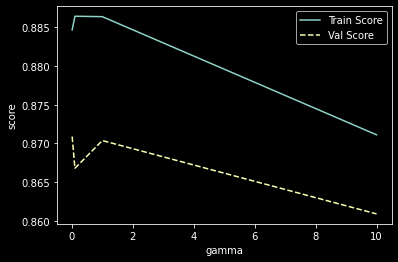

In [175]:
plt.plot(para_gamma, train_score, linestyle ='-', label = "Train Score")
plt.plot(para_gamma, val_score, linestyle ='--', label = "Val Score")
plt.ylabel("score"); plt.xlabel("gamma")
plt.legend()

In [176]:
train_score = []; val_score = [] 
para_subsample = [i/10.0 for i in range(1,10)]
for v_subsample in para_subsample:
    xgb = XGBClassifier(n_estimators = 80, 
                        learning_rate = 0.3,
                        max_depth = 6,
                        min_child_weight = 9,
                        gamma=1,
                        subsample=v_subsample,
                        random_state = 1234) 
    xgb.fit(df_train_x, df_train_y)
    train_pred = xgb.predict(df_train_x)
    val_pred = xgb.predict(df_val_x)
    accuracy_score(df_train_y,train_pred)
    train_score.append(accuracy_score(df_train_y,train_pred))
    val_score.append(accuracy_score(df_val_y,val_pred))
#     train_score.append(xgb.score(df_train_x, df_train_y)) 
#     val_score.append(xgb.score(df_val_x, df_val_y))
    
df_score_n= pd.DataFrame() 
df_score_n["subsample"] = para_subsample 
df_score_n["TrainScore"] = train_score
df_score_n["ValScore"] = val_score

df_score_n.round(3)

,subsample,TrainScore,ValScore
0,0.1,0.863,0.848
1,0.2,0.873,0.855
2,0.3,0.879,0.853
3,0.4,0.882,0.858
4,0.5,0.884,0.862
5,0.6,0.884,0.865
6,0.7,0.888,0.865
7,0.8,0.888,0.866
8,0.9,0.889,0.869


In [177]:
train_score = []; val_score = [] 
para_colsample_bytree = [i/10.0 for i in range(1,10)]
for v_colsample_bytree in para_colsample_bytree:
    xgb = XGBClassifier(n_estimators = 80, 
                        learning_rate = 0.3,
                        max_depth = 6,
                        min_child_weight = 9,
                        gamma=1,
                        subsample=0.9,
                        colsample_bytree = v_colsample_bytree,
                        random_state = 1234) 
    xgb.fit(df_train_x, df_train_y)
    train_pred = xgb.predict(df_train_x)
    val_pred = xgb.predict(df_val_x)
    accuracy_score(df_train_y,train_pred)
    train_score.append(accuracy_score(df_train_y,train_pred))
    val_score.append(accuracy_score(df_val_y,val_pred))
#     train_score.append(xgb.score(df_train_x, df_train_y)) 
#     val_score.append(xgb.score(df_val_x, df_val_y))
    
df_score_n= pd.DataFrame() 
df_score_n["colsample_bytree"] = para_colsample_bytree
df_score_n["TrainScore"] = train_score
df_score_n["ValScore"] = val_score

df_score_n.round(3)

,colsample_bytree,TrainScore,ValScore
0,0.1,0.873,0.866
1,0.2,0.880,0.867
2,0.3,0.882,0.869
3,0.4,0.884,0.869
4,0.5,0.885,0.869
5,0.6,0.886,0.870
6,0.7,0.887,0.871
7,0.8,0.887,0.867
8,0.9,0.888,0.868


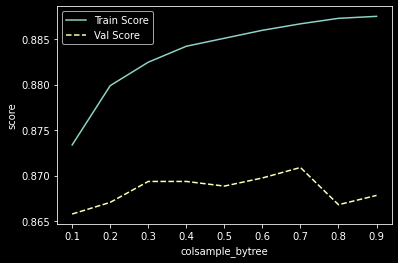

In [178]:
plt.plot(para_colsample_bytree, train_score, linestyle ='-', label = "Train Score")
plt.plot(para_colsample_bytree, val_score, linestyle ='--', label = "Val Score")
plt.ylabel("score"); plt.xlabel("colsample_bytree")
plt.legend()

In [181]:
estimator = XGBClassifier(n_estimators = 80, 
                        learning_rate = 0.3,
                        max_depth = 6,
                        min_child_weight = 9,
                        gamma=1,
                        subsample=0.9,
                        colsample_bytree = 0.7,
                        random_state = 1234
                        )
param_test1 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,15)
}
gsearch1 = GridSearchCV(estimator,param_grid = param_test1, 
                       scoring='accuracy',
                       n_jobs=-1,
                       iid=False, 
                       cv=5, 
                       verbose=10)
gsearch1.fit(df_train_x,df_train_y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

({'mean_fit_time': array([3.25929689, 3.62645888, 3.3821413 , 3.24864588, 3.35774002,
         3.38530517, 3.23504357, 3.27050428, 3.21133943, 3.19953547,
         3.22321463, 3.23122334, 3.45907207, 3.26960859, 4.21269574,
         4.19412055, 4.16261706, 4.07087188, 3.99709888, 4.31558714,
         3.99454355, 4.04743366, 4.01604524, 4.02794638, 4.03144636,
         4.22299647, 4.34960957, 4.38925357, 4.98433022, 4.87509499,
         4.84517813, 5.15825353, 4.88158684, 4.85701828, 4.84372091,
         4.86083884, 5.40574551, 5.10186181, 4.88292527, 4.82355361,
         4.88182049, 4.99567385, 5.94503975, 5.69334083, 5.71687741,
         5.96404243, 6.20327668, 5.70862865, 5.71014194, 5.72546606,
         5.87077432, 5.90547934, 5.75775599, 6.04366136, 6.07899261,
         5.9496356 , 6.53586287, 6.56196737, 6.6150291 , 6.78544087,
         6.69634023, 6.97761936, 6.79489331, 6.67496638, 6.6100008 ,
         6.60381765, 6.80979266, 6.83148384, 7.03673444, 6.62483835,
         7.832462

In [182]:
estimator = XGBClassifier(n_estimators = 80, 
                        learning_rate = 0.3,
                        max_depth = 5,
                        min_child_weight = 7,
                        gamma=1,
                        subsample=0.9,
                        colsample_bytree = 0.7,
                        random_state = 1234
                        )
param_test2 = {
 'gamma':[i/10.0 for i in range(8,12)]
}
gsearch2 = GridSearchCV(estimator,param_grid = param_test2, 
                       scoring='accuracy',
                       n_jobs=-1,
                       iid=False, 
                       cv=5, 
                       verbose=10)
gsearch2.fit(df_train_x,df_train_y)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   20.3s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   25.0s finished


({'mean_fit_time': array([4.87118149, 4.85356731, 5.03225322, 4.90791063]),
  'std_fit_time': array([0.03943746, 0.05403866, 0.18583271, 0.27480289]),
  'mean_score_time': array([0.03135414, 0.03157444, 0.03262963, 0.02528176]),
  'std_score_time': array([0.00077444, 0.00037023, 0.00129371, 0.00526873]),
  'param_gamma': masked_array(data=[0.8, 0.9, 1.0, 1.1],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.8}, {'gamma': 0.9}, {'gamma': 1.0}, {'gamma': 1.1}],
  'split0_test_score': array([0.87332054, 0.87414313, 0.87523992, 0.87167535]),
  'split1_test_score': array([0.87441733, 0.87523992, 0.87551412, 0.87606252]),
  'split2_test_score': array([0.87743351, 0.87277214, 0.87469153, 0.87359474]),
  'split3_test_score': array([0.86646559, 0.86728818, 0.86783658, 0.86893337]),
  'split4_test_score': array([0.87081733, 0.87273725, 0.87383434, 0.87164015]),
  'mean_test_score': array([0.87249086, 0.87243612, 0.8

In [183]:
estimator = XGBClassifier(n_estimators = 80, 
                        learning_rate = 0.3,
                        max_depth = 5,
                        min_child_weight = 7,
                        gamma=1,
                        subsample=0.9,
                        colsample_bytree = 0.7,
                        random_state = 1234
                        )
param_test3 = {
 'subsample':[i/10.0 for i in range(4,12)],
 'colsample_bytree':[i/10.0 for i in range(4,12)]
}
gsearch3 = GridSearchCV(estimator,param_grid = param_test3, 
                       scoring='accuracy',
                       n_jobs=-1,
                       iid=False, 
                       cv=5, 
                       verbose=10)
gsearch3.fit(df_train_x,df_train_y)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3

({'mean_fit_time': array([3.49155965, 3.72714276, 3.70101452, 3.59433227, 3.40293159,
         3.38690715, 3.19181719, 0.07629285, 3.98853869, 4.31219521,
         4.36652761, 4.35586495, 4.22760134, 4.11545386, 3.53049374,
         0.09053998, 4.57572536, 4.96621904, 5.00595565, 4.91984549,
         4.70666304, 4.31344304, 4.11469765, 0.07376108, 5.56610203,
         6.0850862 , 5.86734552, 5.39777551, 5.1465775 , 4.89180799,
         4.66071529, 0.0728519 , 5.92835178, 6.40414705, 6.64272585,
         6.1957448 , 5.9325418 , 5.37172046, 5.02516999, 0.07230825,
         6.31360712, 7.15119271, 7.11332407, 6.9155004 , 6.34002538,
         6.26270757, 5.49178038, 0.07011666, 6.92460456, 7.55917315,
         8.05530415, 7.45833812, 6.8908124 , 6.55455241, 5.85482845,
         0.0765409 , 0.07770848, 0.07547069, 0.07162828, 0.07051883,
         0.07041507, 0.07113795, 0.0692719 , 0.06622543]),
  'std_fit_time': array([0.03976934, 0.03217501, 0.03589784, 0.03817218, 0.01871264,
         0.

In [184]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
estimator = XGBClassifier(n_estimators = 80, 
                        learning_rate = 0.3,
                        max_depth = 5,
                        min_child_weight = 7,
                        gamma=1,
                        subsample=0.9,
                        colsample_bytree = 0.7,
                        random_state = 1234
                        )
gsearch5 = GridSearchCV(estimator,param_grid = param_test5, 
                       scoring='accuracy',
                       n_jobs=-1,
                       iid=False, 
                       cv=5, 
                       verbose=10)
gsearch5.fit(df_train_x,df_train_y)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:   28.4s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   30.6s finished


({'mean_fit_time': array([5.17529874, 5.10605741, 4.87729683, 4.94609995, 2.94646506]),
  'std_fit_time': array([0.07860021, 0.19732943, 0.03771005, 0.03952716, 0.41044577]),
  'mean_score_time': array([0.03287625, 0.03192649, 0.03243113, 0.03231239, 0.02150083]),
  'std_score_time': array([0.00105652, 0.00081412, 0.00082135, 0.00051967, 0.00387949]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.87523992, 0.87332054, 0.87277214, 0.87277214, 0.86098163]),
  'split1_test_score': array([0.87551412, 0.87551412, 0.87551412, 0.87414313, 0.85878804]),
  'split2_test_score': array([0.87469153, 0.87332054, 0.87332054, 0.87140115, 0.85851385]),
  'split3_test_score': array([0.86783658, 0.864272  , 0.86948177,

<a class="anchor" id="평가"></a>
## <center style="background-color:black; width:40%;">모델평가.</center>

In [185]:
df_train_x, df_train_y, mm_scaler1, mm_scaler2, mm_scaler3, mm_scaler4 = prepro(data)
df_train_y = df_train_y.array
df_train_y = df_train_y.to_numpy()
df_train_y = df_train_y.astype(np.int)

In [186]:
from sklearn.metrics import f1_score 
xgb_final = XGBClassifier(n_estimators = 80, 
                        learning_rate = 0.3,
                        max_depth = 5,
                        min_child_weight = 7,
                        gamma=1,
                        subsample=0.9,
                        colsample_bytree = 0.7,
                        reg_alpha = 1e-05,
                        random_state = 1234
                        )
xgb_final.fit(df_train_x,df_train_y)
y_pred = xgb_final.predict(df_val_x)
print('Accuracy on training set:{:.3f}'.format(xgb_final.score(df_train_x,df_train_y)))
print('Accuracy on test set set:{:.3f}\n'.format(xgb_final.score(df_val_x,df_val_y)))
print('Confusion matrix: \n{}'.format(confusion_matrix(df_val_y,y_pred)))
print("XGBoost F1 Score:",f1_score(df_val_y,y_pred, average='micro'))

Accuracy on training set:0.883
Accuracy on test set set:0.880

Confusion matrix: 
[[5579  319]
 [ 622 1295]]
XGBoost F1 Score: 0.8795905310300703


In [187]:
df_test = pd.read_csv('/kaggle/input/kakr-4th-competition/test.csv')
df_test.head()

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0,28,Private,67661,Some-college,10,Never-married,Adm-clerical,Other-relative,White,Female,0,0,40,United-States
1,1,40,Self-emp-inc,37869,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
2,2,20,Private,109952,Some-college,10,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,25,United-States
3,3,40,Private,114537,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
4,4,37,Private,51264,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,99,France


In [190]:
def prepro_test(data, mm_scaler1, mm_scaler2, mm_scaler3, mm_scaler4):
    data_x = data.copy()
    data_x.drop(['id','education','fnlwgt'],axis = 1, inplace = True)
    
    data['log_capital_gain'] = data['capital_gain'].map(lambda x : np.log(x, where=(x!=0)))
    data['log_capital_loss'] = data['capital_loss'].map(lambda x : np.log(x, where=(x!=0)))

    
    data_x['occupation'][data['occupation'] =='?'] = 'Unknown'
    data_x['native_country'][data['native_country'] =='?'] = 'unknown_country'
    data_x['workclass'][data['workclass'] =='?'] = 'unknown_workclass'
    data_x['mm_age'] = mm_scaler1.transform(data_x['age'].values.reshape(-1,1))

    data_x['mm_capital_gain'] = mm_scaler2.transform(data['log_capital_gain'].values.reshape(-1,1))
    data_x['mm_capital_loss'] = mm_scaler3.transform(data['log_capital_loss'].values.reshape(-1,1))
    
    data_x['mm_hours_per_week'] = mm_scaler4.transform(data_x['hours_per_week'].values.reshape(-1,1))
    data_x.drop(['age','capital_gain','capital_loss','hours_per_week'], axis = 1, inplace = True)
    
    cols = ['workclass', 'occupation', 'marital_status','relationship','race','native_country','sex']
    for col in cols:
        data_dummy = pd.get_dummies(data_x[col])
        data_x = pd.concat([data_x, data_dummy], axis = 1)
        data_x.drop([col] ,axis = 1, inplace = True)
    data_x.drop(['Holand-Netherlands'], axis = 1, inplace = True)
    data_x.astype(int)
    data_y.astype(int)
    return data_x, data_y

In [191]:
df_test_x, df_test_y = prepro_test(df_test, mm_scaler1, mm_scaler2, mm_scaler3, mm_scaler4)
df_test_y = df_test_y.array
df_test_y = df_test_y.to_numpy()
df_test_y = df_test_y.astype(np.int)

KeyError: "['fnlwgt'] not found in axis"

In [93]:
df_test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6512 entries, 0 to 6511
Data columns (total 92 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   education_num               6512 non-null   int64  
 1   mm_age                      6512 non-null   float64
 2   mm_capital_gain             6512 non-null   float64
 3   mm_capital_loss             6512 non-null   float64
 4   mm_hours_per_week           6512 non-null   float64
 5   mm_fnlwgt                   6512 non-null   float64
 6   Federal-gov                 6512 non-null   uint8  
 7   Local-gov                   6512 non-null   uint8  
 8   Never-worked                6512 non-null   uint8  
 9   Private                     6512 non-null   uint8  
 10  Self-emp-inc                6512 non-null   uint8  
 11  Self-emp-not-inc            6512 non-null   uint8  
 12  State-gov                   6512 non-null   uint8  
 13  Without-pay                 6512 

In [94]:
df_train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18234 entries, 23632 to 25299
Data columns (total 91 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   education_num               18234 non-null  int64  
 1   mm_age                      18234 non-null  float64
 2   mm_capital_gain             18234 non-null  float64
 3   mm_capital_loss             18234 non-null  float64
 4   mm_hours_per_week           18234 non-null  float64
 5   mm_fnlwgt                   18234 non-null  float64
 6   Federal-gov                 18234 non-null  uint8  
 7   Local-gov                   18234 non-null  uint8  
 8   Never-worked                18234 non-null  uint8  
 9   Private                     18234 non-null  uint8  
 10  Self-emp-inc                18234 non-null  uint8  
 11  Self-emp-not-inc            18234 non-null  uint8  
 12  State-gov                   18234 non-null  uint8  
 13  Without-pay                

In [100]:
sample_submission = pd.read_csv('/kaggle/input/kakr-4th-competition/sample_submission.csv')

In [101]:
sample_submission['prediction'] = xgb_final.predict(df_test_x).astype(int)

In [102]:
sample_submission.to_csv('submission.csv', index = False)